## CoT Final Report

In [1]:
import os
import sys
from datetime import datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import scipy.stats as scs

import sklearn as sk
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV,LassoCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

import statsmodels as smm
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA

import pygam
from pygam import LinearGAM
from pygam import s,l,f,te

import warnings
import time
warnings.filterwarnings("ignore")



In [89]:
df_raw=pd.read_csv('Data_Weekly_20201204.csv',index_col = "Date", parse_dates = True)

#Drop price columns
cols = ['XAU','JNK', 'SPX Index','W5000', 'NASDAQ', 'USD_TWFX', 'USD_BrettFX', 'EUR',  'JPY','JNK_Volm']
df = df_raw.drop(columns = cols)

#add 2020 to a df
df_insane = df.iloc[-48:,:]

#remove 2020 from the sample
df = df.iloc[:-48,:]

#train period 6/22/10 - 12/26/17; test 1/2/2018 - 12/31/2019
df_train = df.iloc[:390,:]
df_test = df.iloc[390:,:]

diff_score = pd.DataFrame(index = ['Benchmark', 'Lasso', 'Ridge','ElasticNet','HMM','GAM',\
                              'SVR','RF','GBM','VARMAX'], columns = ["MSE","MAE","APE"])
pos_score = pd.DataFrame(index = ['Benchmark', 'Lasso', 'Ridge','ElasticNet','HMM','GAM',\
                              'SVR','RF','GBM','VARMAX'], columns = ["MSE","MAE","APE"])

roll_score = pd.DataFrame(index = ['Benchmark', 'Lasso', 'Ridge','ElasticNet','HMM','GAM',\
                              'SVR','RF','GBM','VARMAX'], columns = ["MSE","MAE","APE"])


MSE  MAE  APE
Benchmark   NaN  NaN  NaN
Lasso       NaN  NaN  NaN
Ridge       NaN  NaN  NaN
ElasticNet  NaN  NaN  NaN
HMM         NaN  NaN  NaN
GAM         NaN  NaN  NaN
SVR         NaN  NaN  NaN
RF          NaN  NaN  NaN
GBM         NaN  NaN  NaN
VARMAX      NaN  NaN  NaN

In [101]:
def plotMissing(df,save=False,title='Missing Values'):
    #Missing value plot
    plt.figure(figsize=(8,6))
    sns.heatmap(df.isnull(),cbar=False)
    #sns.heatmap(df.iloc[np.unique(np.where(df.isnull())[0]),:].isnull(),cbar=False)
    plt.title('Missing Value')
    plt.tight_layout()
    if save:
        plt.savefig(title,dpi=300)
    plt.show()

def tsplot1(y, lags=None, figsize = (11,8), style = 'bmh',title = None):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2,3)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan = 3) 
        acf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,2))
        y.plot(ax = ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags = lags, ax=acf_ax, alpha = 0.05) #autocorrelations, alpha is the hypothesis testing error bars.
        sm.qqplot(y, line = 's', ax=qq_ax)
        plot_pacf(y, lags = lags,alpha = .05, ax =pacf_ax )
        qq_ax.set_title('QQ PLot')
        plt.tight_layout() #keep into tight configuration. 
    return


def compareplot(y,y_pred,figsize):
    fig = plt.figure(figsize = (10,6))
    plt.plot(y_pred, label = "Forecast")
    plt.plot(y, label = "AM_N_Pos")
    plt.tight_layout()
    plt.legend()

def scorecard(method,err,y):
    global pos_score
    mse=np.round(np.mean(err**2)/1000000000,3)
    mae=np.round(np.mean(np.abs(err)),3)
    ape=np.round(np.mean(np.abs((err)/y)),3)
    pos_score.loc[method]['MSE','MAE','APE'] = mse, mae, ape
    print("Model:",method)
    print('MSE is {0:.2f}'.format(mse))
    print('MAE is {0:.2f}'.format(mae))
    print('Average Percentage Error is {0:.2f}'.format(ape))


def evaluate(method, y, y_pred,lags = None, figsize = (11,8), style = 'bmh'):
    err = y - y_pred
    scorecard(method,err,y)
    #compareplot(y,y_pred,figsize)
    if not isinstance(err,pd.Series):
        err = pd.Series(err)
    with plt.style.context(style):
        fig = plt.figure(figsize = figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0),colspan = 2)
        qq_ax = plt.subplot2grid(layout,(1,0))
        acf_ax = plt.subplot2grid(layout,(1,1))
        err.plot(ax = ts_ax)
        ts_ax.set_title('Residuals Plot')
        smt.graphics.plot_acf(err,lags = lags, ax = acf_ax, alpha = .05)
        sm.qqplot(err,line = 's',ax = qq_ax)
        qq_ax.set_title('QQ Plot')
        plt.tight_layout()
    return


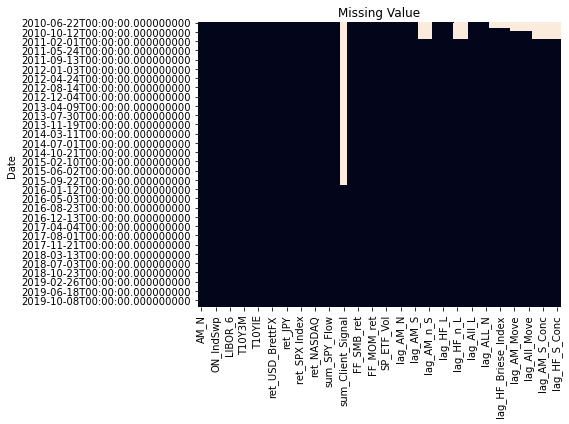

In [4]:
plotMissing(df)

__Net Positions of Asset Managers in The Commitments of Traders__<br>
The time series exhibits significant autocorrelation, with the partial autocorrelation function suggesting an AR(1) process.  Ljung Box test shows significance through the 10th lag.

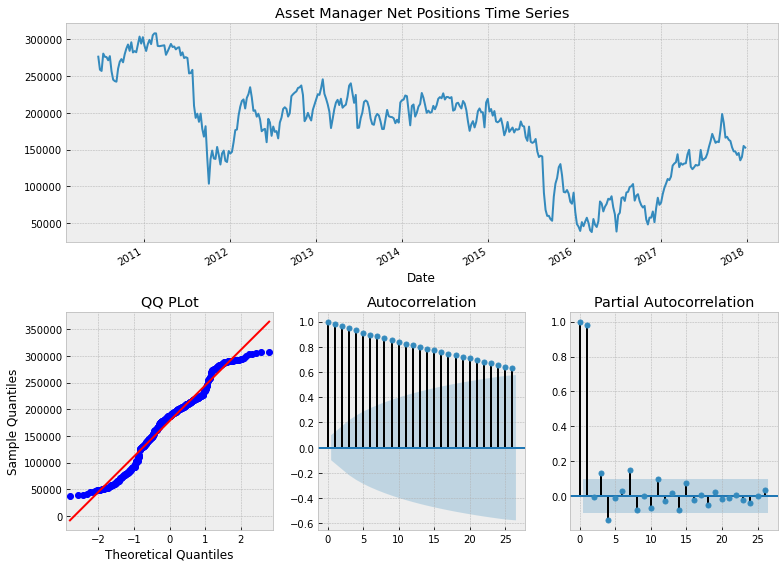

In [5]:
tsplot1(df_train['AM_N'],title = 'Asset Manager Net Positions Time Series')

In [6]:
acorr_ljungbox(df_train['AM_N'], lags = 100, return_df = True).iloc[:3,:]

lb_stat      lb_pvalue
1   378.211180   3.050829e-84
2   743.057888  4.436390e-162
3  1098.294932  8.530613e-238

In [7]:
res = sm.tsa.arma_order_select_ic(df_train['AM_N'], ic=['aic', 'bic'], trend = 'nc')
print("AIC Order Select:",res.aic_min_order)
print("BIC Order Select:",res.bic_min_order)

AIC Order Select: (2, 1)
BIC Order Select: (2, 1)


For simplicity, we'll assume AM Net Positions are AR(1) and form our prediction around both the difference and level of the repsonse with the lagged response as a predictor.  There did not appear to be a strong indication for AR(2) in the PACF.

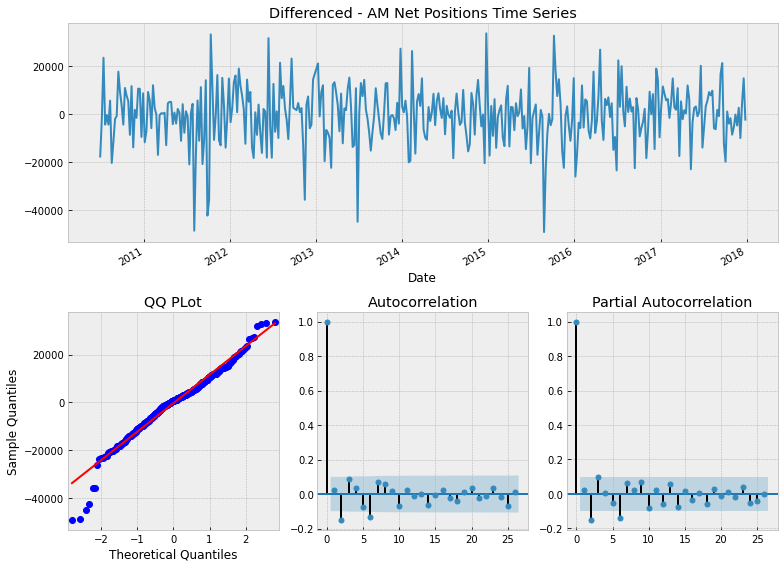

In [8]:
#Differencing
AM_N_diff = df_train['AM_N'].diff().dropna()
tsplot1(AM_N_diff,title = 'Differenced - AM Net Positions Time Series')

In [9]:
res = sm.tsa.arma_order_select_ic(AM_N_diff, ic=['aic', 'bic'], trend = 'nc')
print("AIC Order Select:",res.aic_min_order)
print("BIC Order Select:",res.bic_min_order)

AIC Order Select: (1, 1)
BIC Order Select: (1, 1)


In [10]:
#Correlation: Compute the correlation matrix
def plotCorr(labeled,save=False):
    s=10
    corr = labeled.iloc[:,:-1].corr()

    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    #sns.set_theme(style="white")
    f, ax = plt.subplots(figsize=(16, 16))
    ax = sns.heatmap(corr, square=True,linewidths=.4,annot=True,annot_kws={"size":8},fmt='.1f',cbar_kws={"shrink": .4}, mask=mask, cmap="coolwarm")
    # Draw the heatmap with the mask and correct aspect ratio
    plt.tight_layout()
    plt.title('Correlation Matrix',size=s)
    if save:
        plt.savefig('Correlation Matrix',dpi=300)
    plt.show()

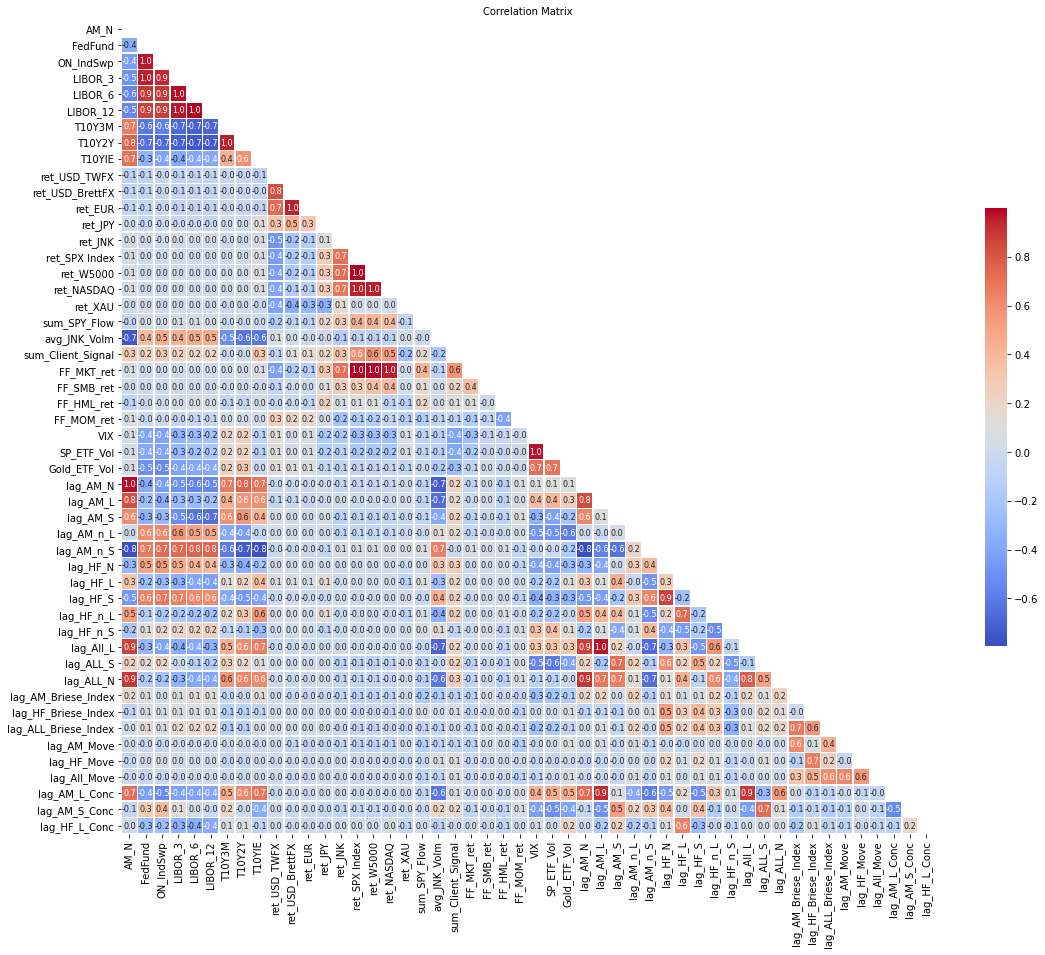

In [11]:
plotCorr(df_train,save=False)

__Predictor Distributions__

In [12]:
Asset = {'AM Position':['lag_AM_N','lag_AM_L','lag_AM_S'],
         'HF Position':['lag_HF_N','lag_HF_L','lag_HF_S'],
         'All Position':['lag_All_L', 'lag_ALL_S', 'lag_ALL_N'],
         'Concentration':['lag_AM_L_Conc', 'lag_AM_S_Conc','lag_HF_L_Conc', 'lag_HF_S_Conc'],
         'Sentiment':['lag_AM_Briese_Index', 'lag_HF_Briese_Index', 'lag_ALL_Briese_Index'],
         'Movement' :['lag_AM_Move','lag_HF_Move','lag_All_Move'],
         'Int_Rate':['FedFund', 'ON_IndSwp'],
         'LIBOR':['LIBOR_3', 'LIBOR_6','LIBOR_12'],
         'YTM Spread':['T10Y3M','T10Y2Y'],
         'Inflation':['T10YIE'],
         'FX Returns': [ 'ret_USD_TWFX','ret_USD_BrettFX', 'ret_EUR','ret_JPY'],      
         'Junk_Bond Returns':['ret_JNK'],
         'Equity Returns':['ret_SPX Index','ret_W5000', 'ret_NASDAQ'],
         'FamaFrench':['FF_MKT_ret', 'FF_SMB_ret', 'FF_HML_ret', 'FF_MOM_ret'],
         'ETF_Flows':['sum_SPY_Flow'],
         'Vol':['VIX', 'SP_ETF_Vol', 'Gold_ETF_Vol'],
         'Signal':['sum_Client_Signal'],
         'Commodity':['ret_XAU']       
        }
key_list = list(Asset.keys())

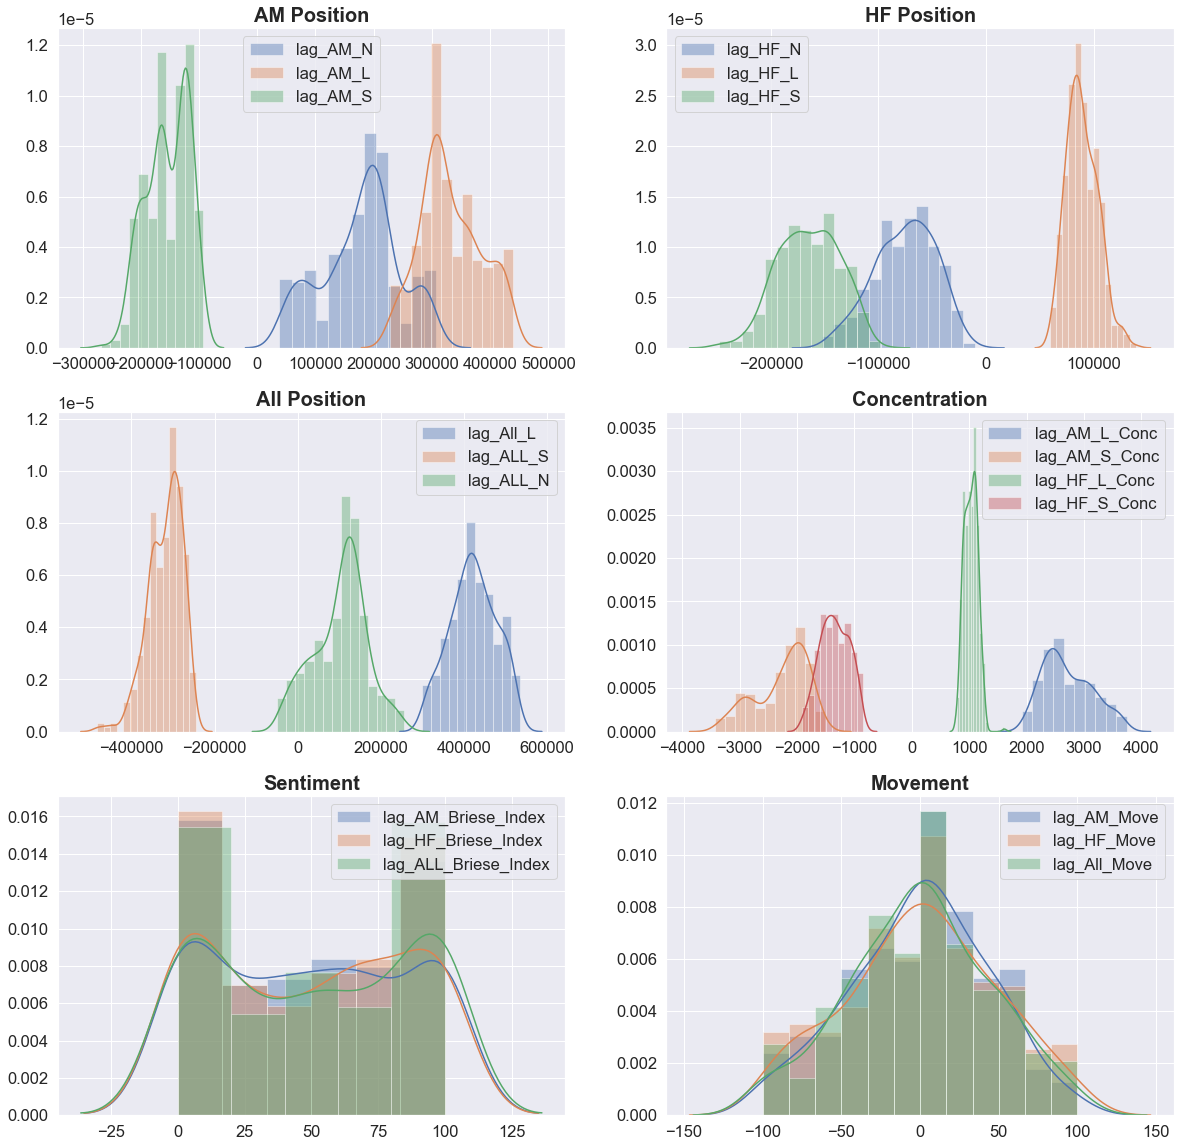

In [13]:
#look at one of each Asset Type Across Time
fig = plt.figure(figsize = (20,20))
sns.set(font_scale = 1.5)
axs = fig.subplots(3,2)
keys_cur = key_list[0:6]
for j in range(len(keys_cur)):    
    item_names = Asset[keys_cur[j]]
    for i in range(len(item_names)):
        axs[j//2, j%2].set_ylabel("Distribution", fontsize = 15)
        axs[j//2, j%2].set_ylabel("", fontsize = 15)
        axs[j//2, j%2].set_title(keys_cur[j], fontsize = 20,fontweight="bold")
        #if(item_names[i][-2:]=="_S"):
        #    x = pd.Series(-df.loc[:,item_names[i]], name = "")
        #else:
        x = pd.Series(df_train.loc[:,item_names[i]], name = "")
        sns.distplot(x, label = item_names[i],ax=axs[j//2,j%2])
    axs[j//2, j%2].legend()

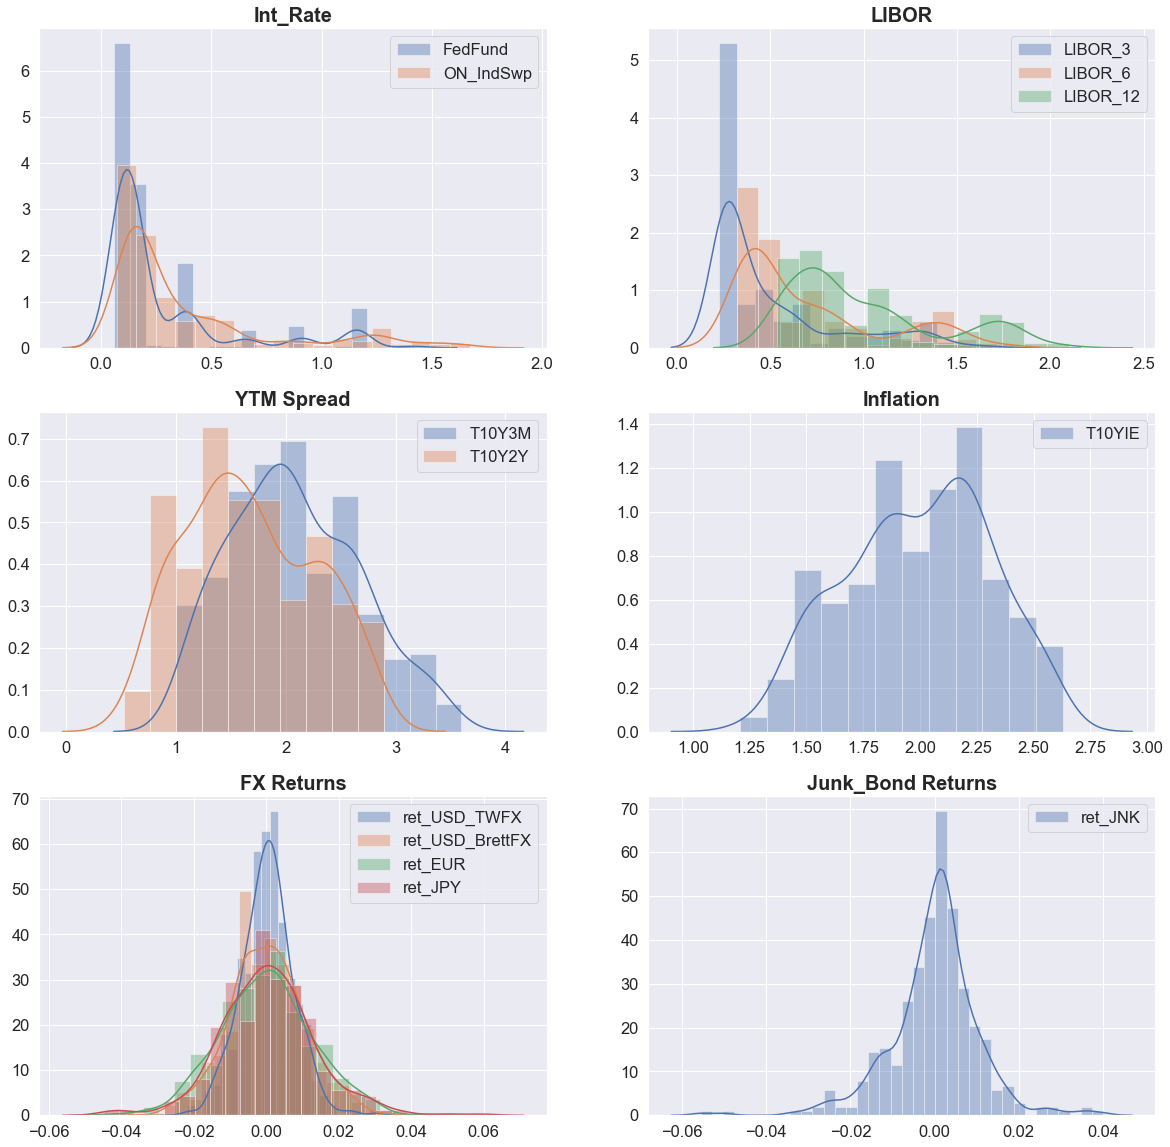

In [14]:
#look at one of each Asset Type Across Time
fig = plt.figure(figsize = (20,20))
sns.set(font_scale = 1.5)
axs = fig.subplots(3,2)
keys_cur = key_list[6:12]
for j in range(len(keys_cur)):    
    item_names = Asset[keys_cur[j]]
    for i in range(len(item_names)):
        axs[j//2, j%2].set_ylabel("Distribution", fontsize = 15)
        axs[j//2, j%2].set_ylabel("", fontsize = 15)
        axs[j//2, j%2].set_title(keys_cur[j], fontsize = 20,fontweight="bold")
        if(item_names[i][-6:]=="Signal"):
            scaler = preprocessing.StandardScaler()
            scaled_sig = scaler.fit_transform(df.loc[:,item_names[i]])
            x = pd.Series(scaled_sig, name = "")
        else:
            x = pd.Series(df_train.loc[:,item_names[i]], name = "")
        sns.distplot(x, label = item_names[i],ax=axs[j//2,j%2])
    axs[j//2, j%2].legend()

In [15]:
#standardize client signal
z = df_train['sum_Client_Signal']
z = z.dropna()
mean = np.mean(z)
std = np.std(z)
z = (z-mean)/std

#look at one of each Asset Type Across Time



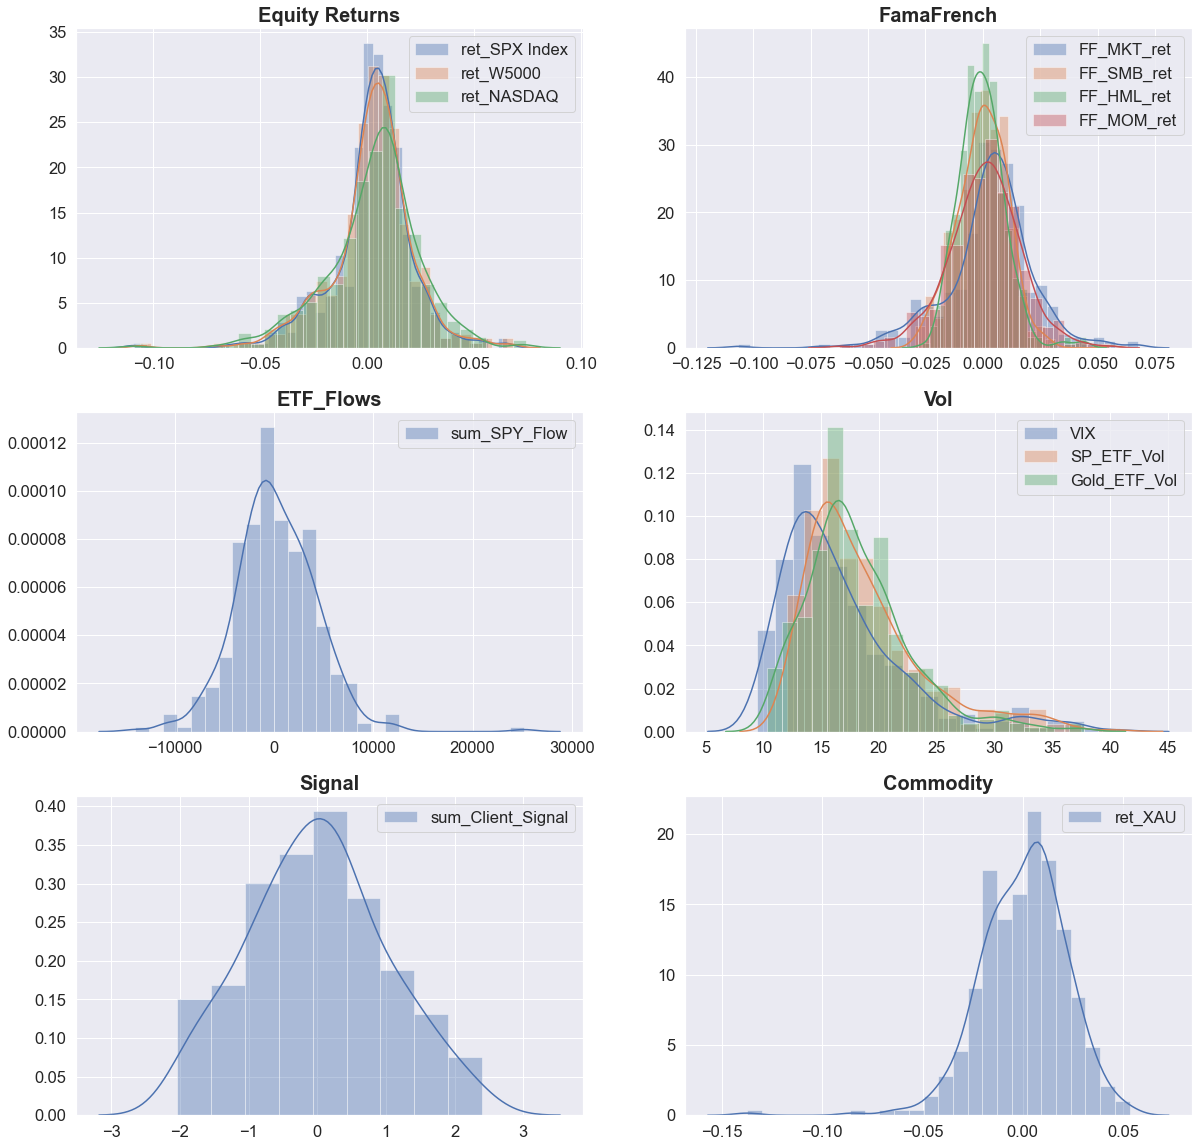

In [16]:
fig = plt.figure(figsize = (20,20))
sns.set(font_scale = 1.5)
axs = fig.subplots(3,2)
keys_cur = key_list[12:18]
for j in range(len(keys_cur)):    
    item_names = Asset[keys_cur[j]]
    for i in range(len(item_names)):
        axs[j//2, j%2].set_ylabel("Distribution", fontsize = 15)
        axs[j//2, j%2].set_ylabel("", fontsize = 15)
        axs[j//2, j%2].set_title(keys_cur[j], fontsize = 20,fontweight="bold")
        if(item_names[i][-6:]=="Signal"):
            x = pd.Series(z, name = "")
        else:
            x = pd.Series(df_train.loc[:,item_names[i]], name = "")
        sns.distplot(x, label = item_names[i],ax=axs[j//2,j%2])
    axs[j//2, j%2].legend()

In [17]:
df_train['year'] = df_train.index.year
y_train = df_train['AM_N']

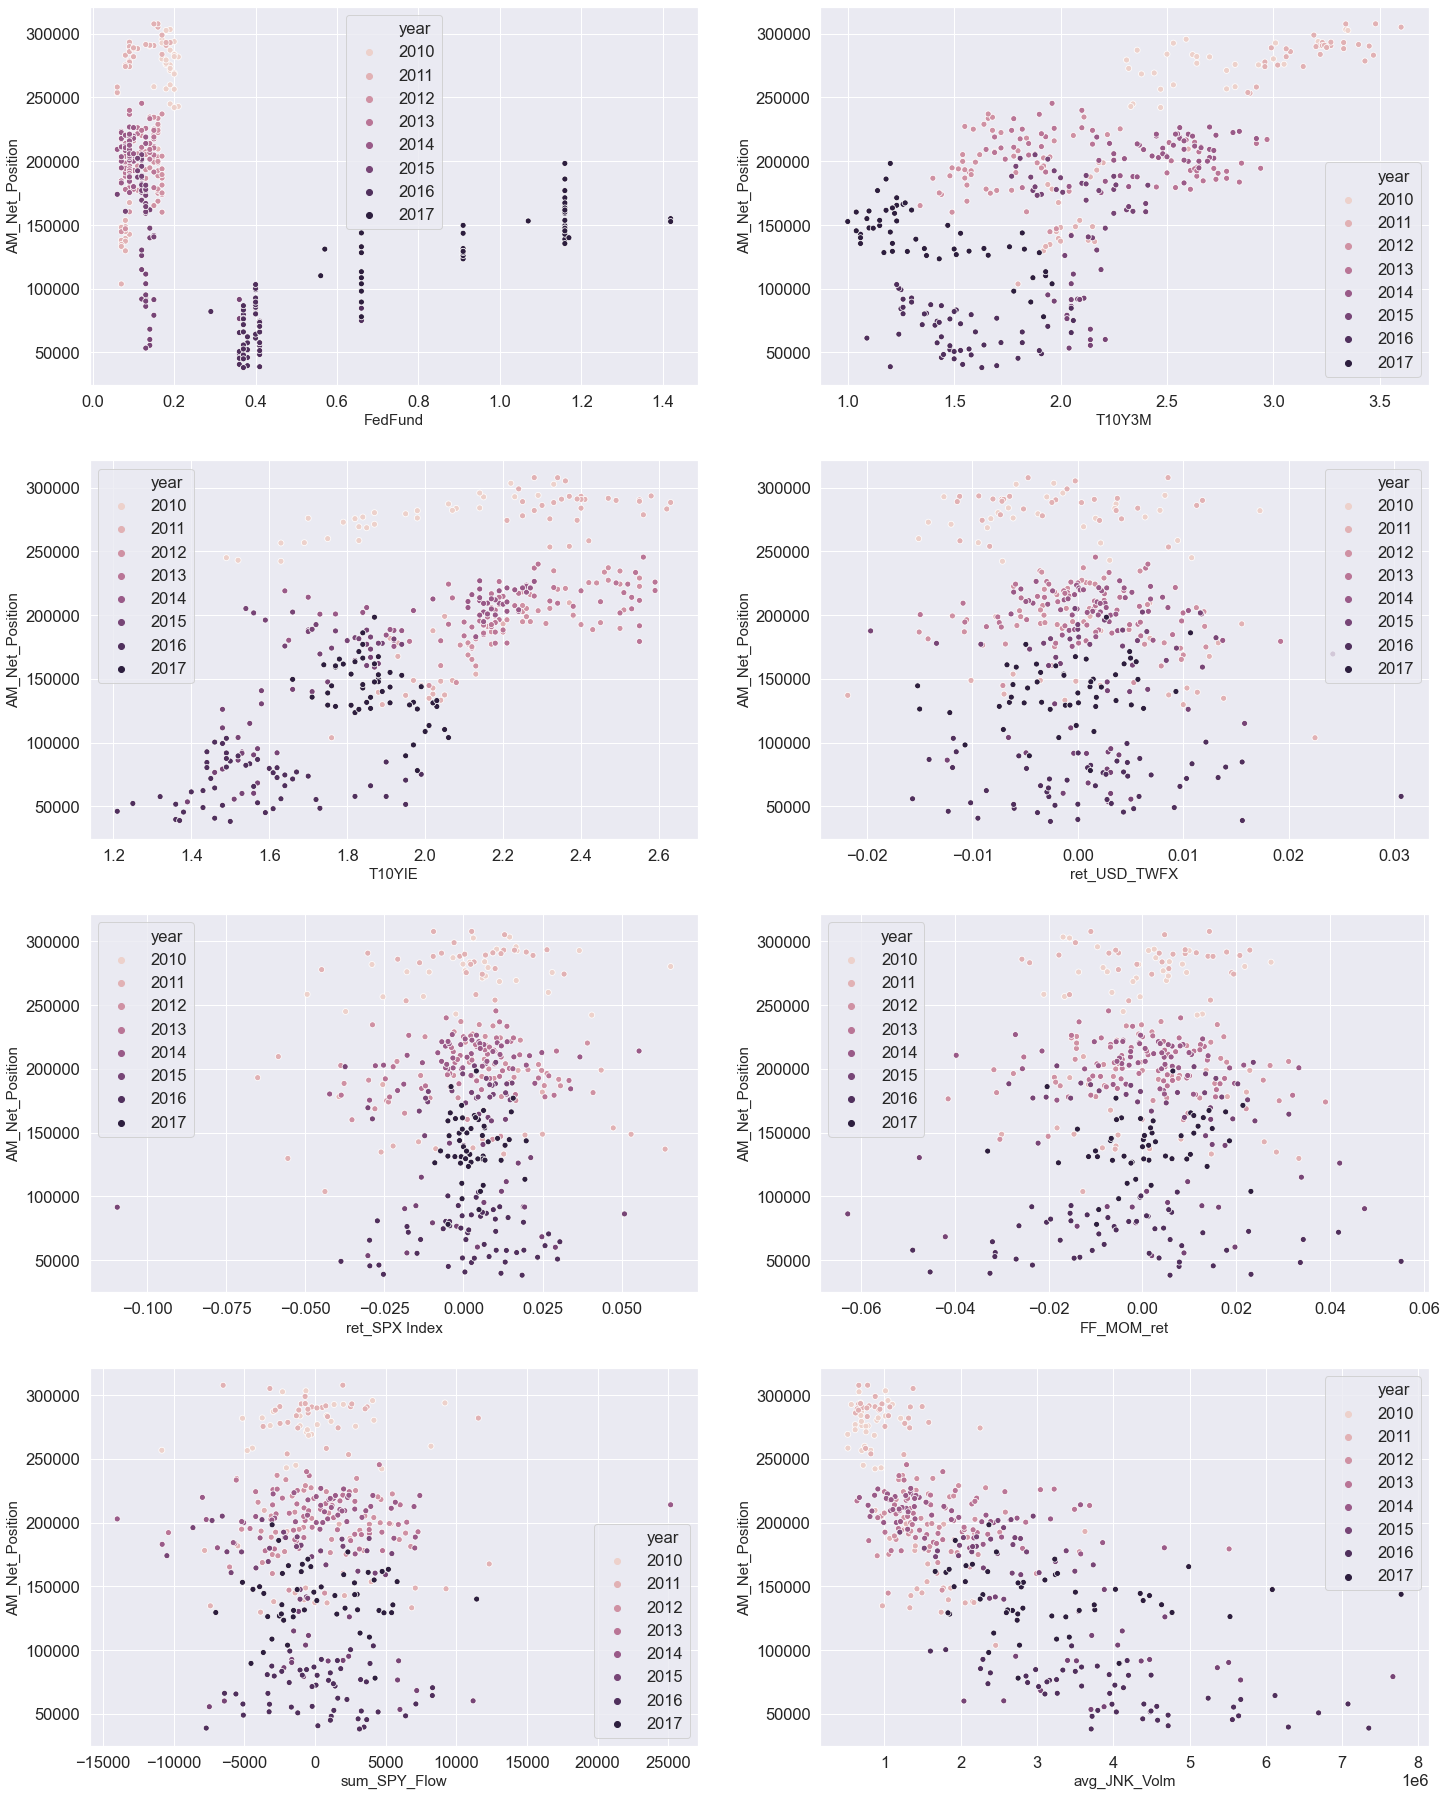

In [18]:
#look at one of each Asset Type Across Time
fig = plt.figure(figsize = (24,32))
sns.set(font_scale = 1.5)
axs = fig.subplots(4,2)
picklst = ['FedFund','T10Y3M','T10YIE','ret_USD_TWFX','ret_SPX Index','FF_MOM_ret','sum_SPY_Flow','avg_JNK_Volm']
for i in range(8):
    sns.scatterplot(x=df_train.loc[:,picklst[i]], y=y_train, data=df_train, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("AM_Net_Position", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)

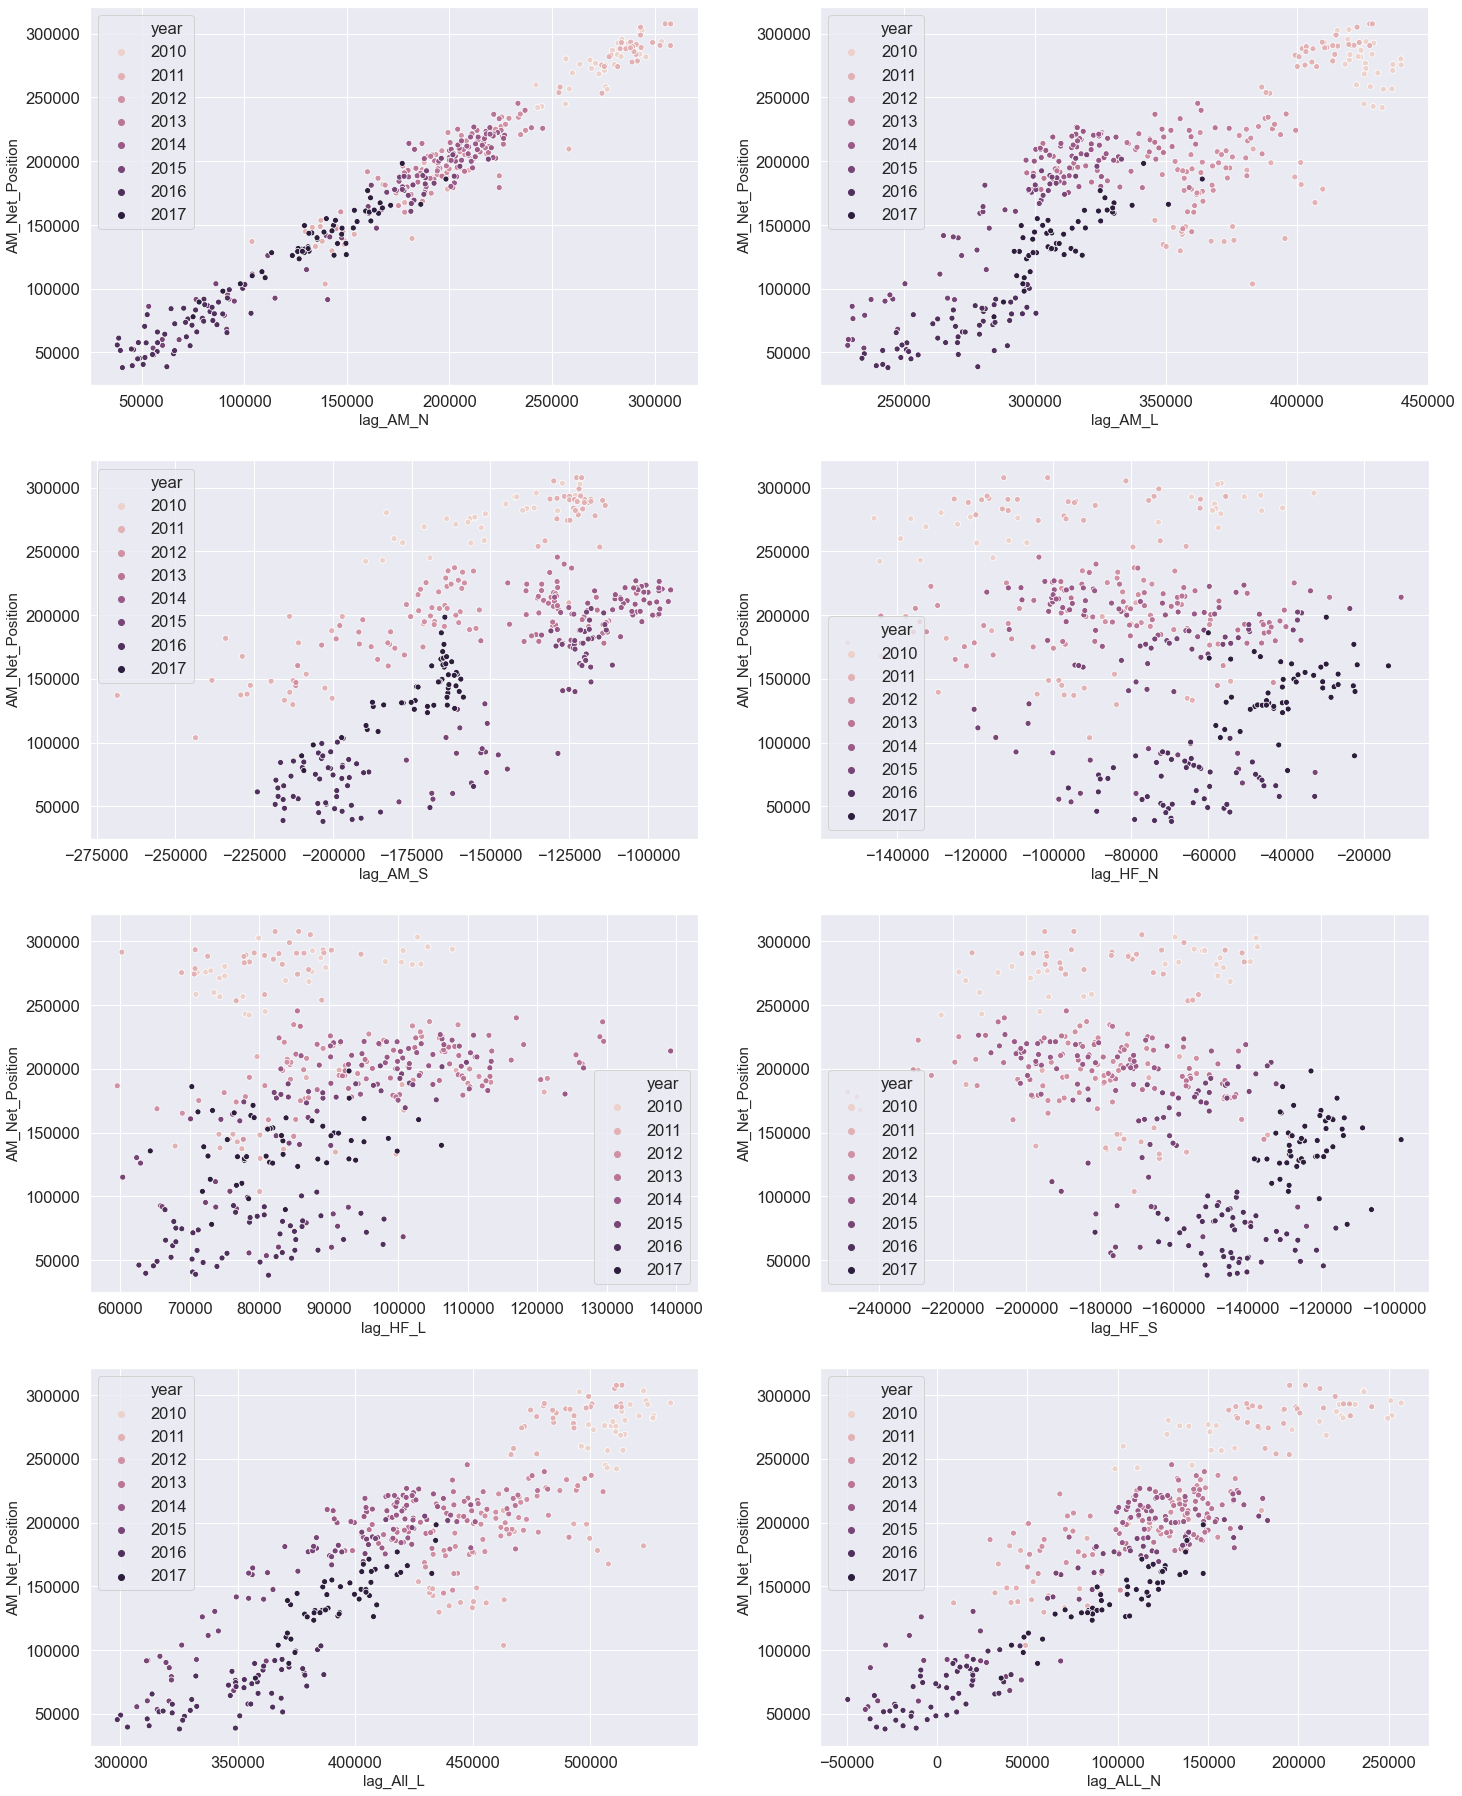

In [19]:
fig = plt.figure(figsize = (24,32))
sns.set(font_scale = 1.5)
axs = fig.subplots(4,2)
picklst = ['lag_AM_N','lag_AM_L', 'lag_AM_S', 'lag_HF_N', 'lag_HF_L', 'lag_HF_S', 'lag_All_L', 'lag_ALL_N']
for i in range(8):
    sns.scatterplot(x=df_train.loc[:,picklst[i]], y=y_train, data=df_train, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("AM_Net_Position", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)


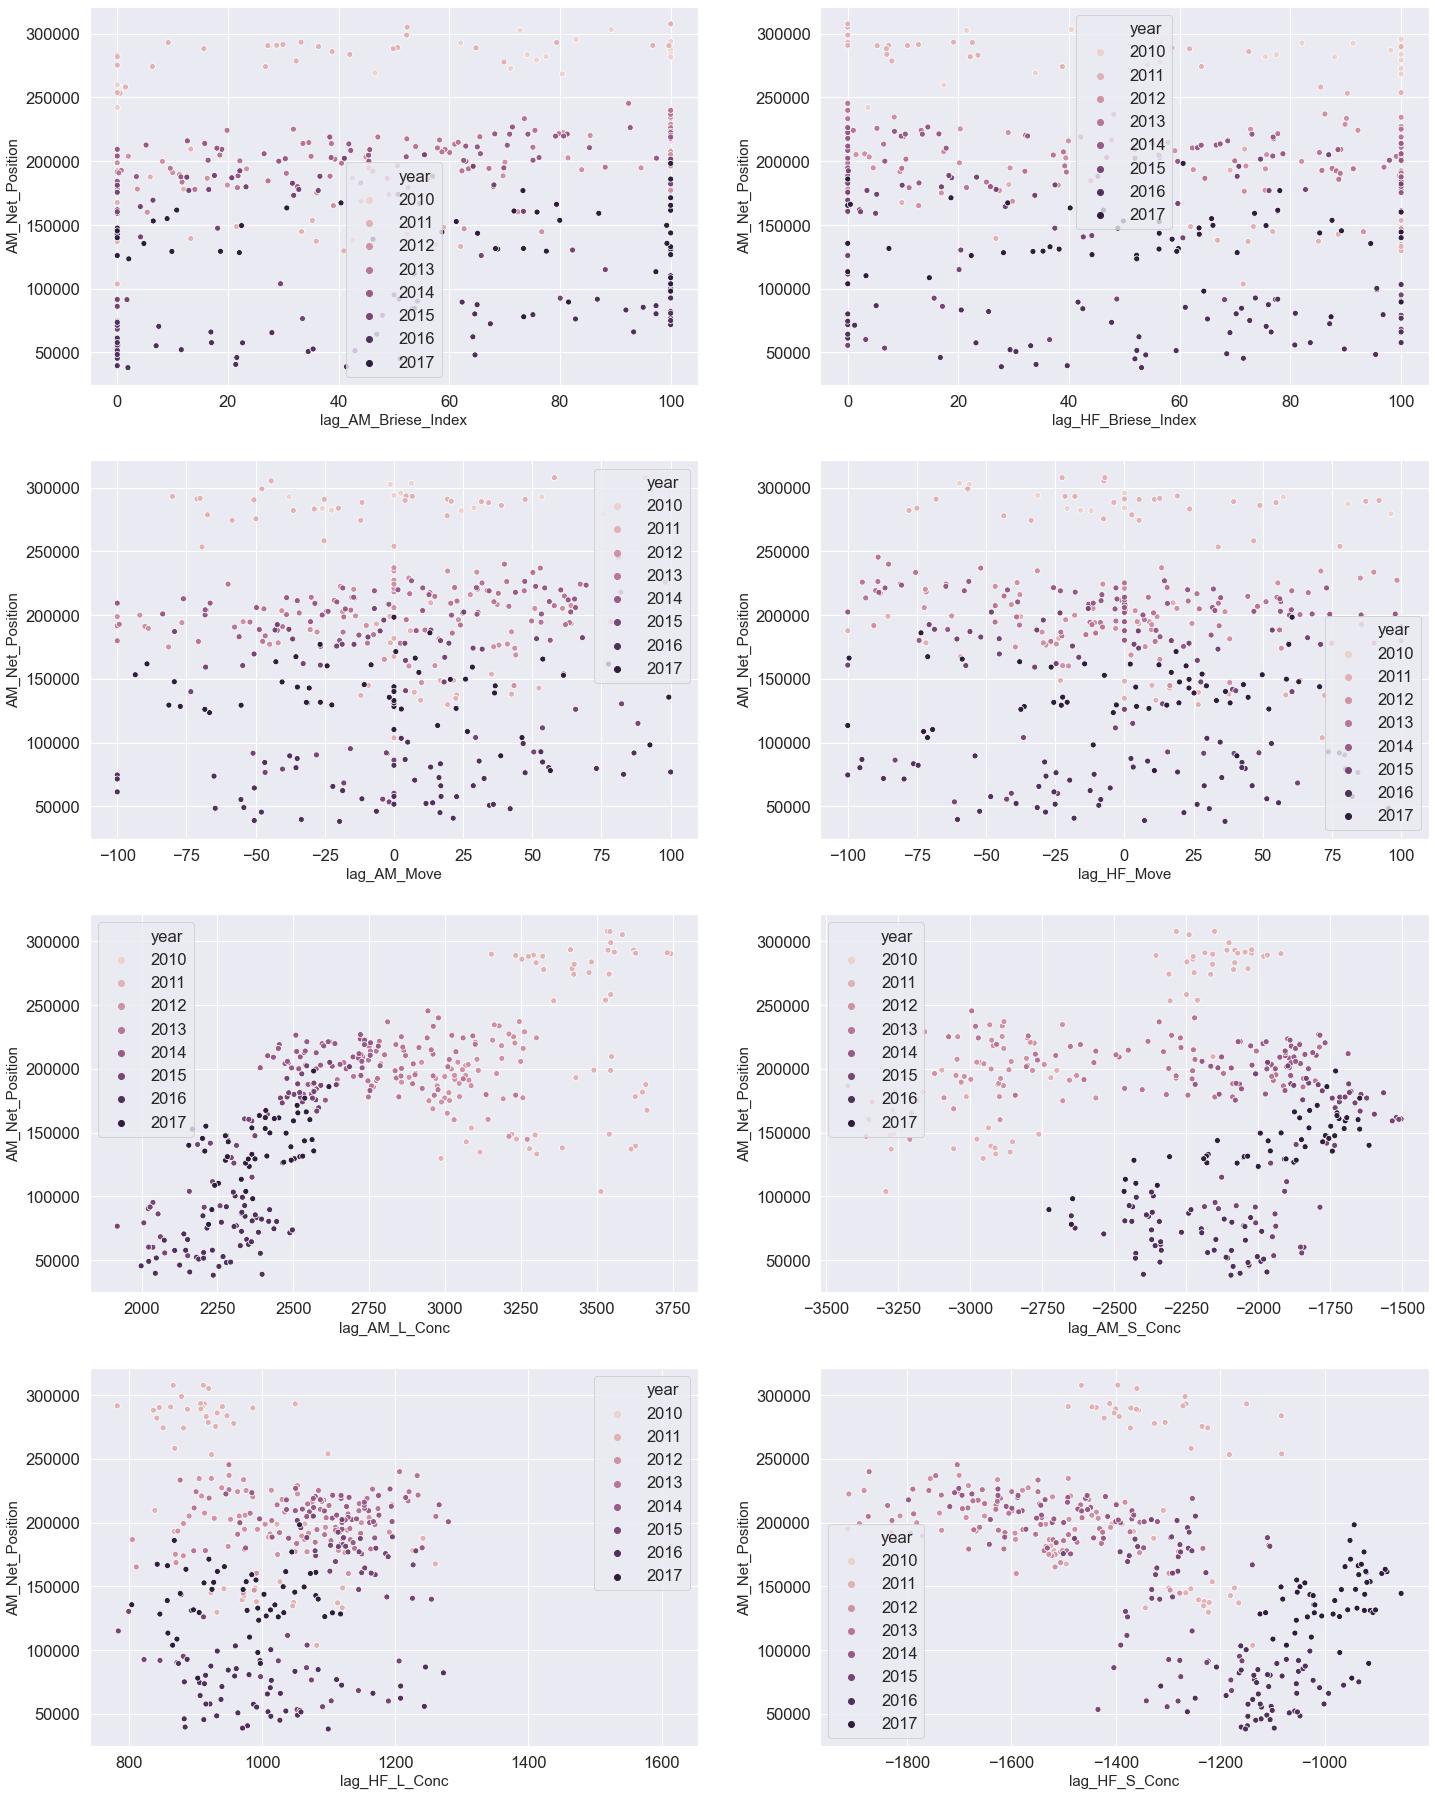

In [20]:
fig = plt.figure(figsize = (24,32))
sns.set(font_scale = 1.5)
axs = fig.subplots(4,2)
picklst = ['lag_AM_Briese_Index', 'lag_HF_Briese_Index','lag_AM_Move', 'lag_HF_Move', 
       'lag_AM_L_Conc', 'lag_AM_S_Conc', 'lag_HF_L_Conc', 'lag_HF_S_Conc']
for i in range(8):
    sns.scatterplot(x=df_train.loc[:,picklst[i]],y=y_train, data=df_train, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("AM_Net_Position", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)


__Benchmark Model__<br>
For the benchmark model, we will attempt to predict the AM_Net_Pos level based on the previous week's value

In [98]:
y_train = df_train['AM_N']
X_train = df_train['lag_AM_N']
X_train = sm.add_constant(X_train)
y_test = df_test['AM_N']
X_test = df_test['lag_AM_N']
X_test = sm.add_constant(X_test)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [99]:
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   AM_N   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                 1.181e+04
Date:                Wed, 16 Dec 2020   Prob (F-statistic):          1.22e-292
Time:                        11:29:24   Log-Likelihood:                -4211.5
No. Observations:                 390   AIC:                             8427.
Df Residuals:                     388   BIC:                             8435.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2911.0031   1719.576      1.693      0.0

Model: Benchmark
MSE is 0.21
MAE is 10759.58
Average Percentage Error is 0.09


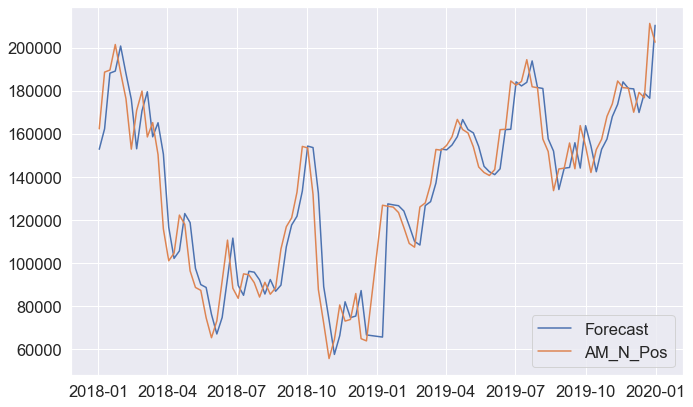

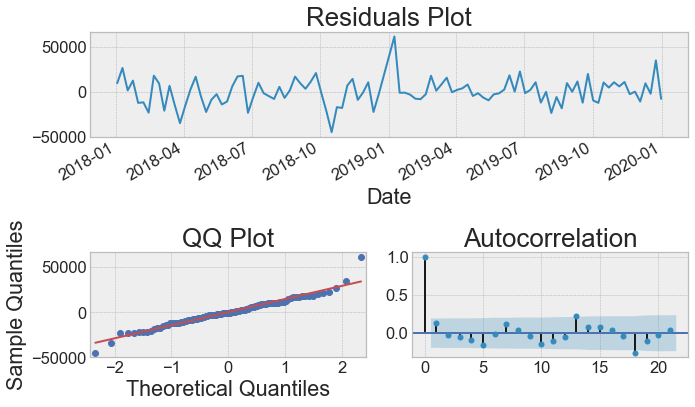

In [100]:
y_pred = results.predict(X_test)
evaluate('Benchmark', y_test, y_pred,lags = None, figsize = (10,6), style = 'bmh')

Model: Benchmark
MSE is 0.21
MAE is 10759.58
Average Percentage Error is 0.09


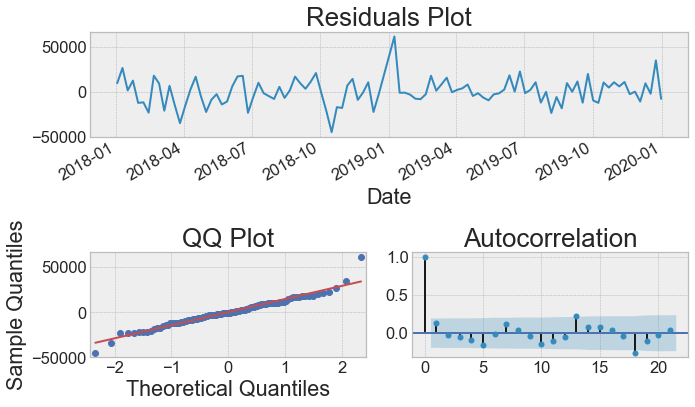

In [102]:
evaluate('Benchmark', y_test, y_pred,lags = None, figsize = (10,6), style = 'bmh')

In [95]:
pos_score['MSE']['Benchmark'] = MSE
pos_score['MAE']['Benchmark'] = MAE
pos_score['APE']['Benchmark'] = APE


In [96]:
pos_score

MSE      MAE       APE
Benchmark   122.573  8248.25  0.071527
Lasso           NaN      NaN       NaN
Ridge           NaN      NaN       NaN
ElasticNet      NaN      NaN       NaN
HMM             NaN      NaN       NaN
GAM             NaN      NaN       NaN
SVR             NaN      NaN       NaN
RF              NaN      NaN       NaN
GBM             NaN      NaN       NaN
VARMAX          NaN      NaN       NaN

__Rolling Estimation__<br>
We begin with a rolling estimation window as a way to address local changes in predictor relationships

In [40]:
#Test to ensure rolling window logic functions correctly
"""
est = 123
wind = 5
rebal_count = (periods-est)//wind
print(periods)
print(est)
print(wind)
print(rebal_count)

for i in range (0,rebal_count):
    print("Rebal #:",i+1)
    print("ESTIMATION________________")
    full = df.iloc[i*wind:est+i*wind+wind,:].index
    print("Starts :",full[0])
    print("Stops  :",full[-1])
    train = full[:est]
    print("TRAIN____________________")
    print("Starts :",train[0])
    print("Stops  :",train[-1])
    test = full[ est : est+ wind]
    print("TEST____________________")
    print("Starts :",test[0])
    print("Stops  :",test[-1])
    print("\n")
"""

'\nest = 123\nwind = 5\nrebal_count = (periods-est)//wind\nprint(periods)\nprint(est)\nprint(wind)\nprint(rebal_count)\n\nfor i in range (0,rebal_count):\n    print("Rebal #:",i+1)\n    print("ESTIMATION________________")\n    full = df.iloc[i*wind:est+i*wind+wind,:].index\n    print("Starts :",full[0])\n    print("Stops  :",full[-1])\n    train = full[:est]\n    print("TRAIN____________________")\n    print("Starts :",train[0])\n    print("Stops  :",train[-1])\n    test = full[ est : est+ wind]\n    print("TEST____________________")\n    print("Starts :",test[0])\n    print("Stops  :",test[-1])\n    print("\n")\n'

In [63]:
def Lasso(X_train_std, X_test_std, y_train): 
    lasso = LassoCV(max_iter = 10000, alphas = np.logspace(.1,3,100))
    lasso.fit(X_train_std, y_train)
    forecast = lasso.predict(X_test_std)
    coef = lasso.coef_
    alpha = lasso.alpha_      
    return  coef, alpha, forecast

def Ridge(X_train_std, X_test_std, y_train): 
    lasso = LassoCV(max_iter = 10000, alphas = np.logspace(.1,3,100))
    lasso.fit(X_train_std, y_train)
    forecast = lasso.predict(X_test_std)
    coef = lasso.coef_
    alpha = lasso.alpha_      
    return  coef, alpha, forecast


def Rolling(PredModel, est_window, pred_window):    
    periods = df.shape[0]
    est = est_window
    wind = pred_window
    rebal_count = (periods-est)//wind    #need to include initial estimation
    idx = df.iloc[est:,:].index
    alphas = []
    pred = []
    MSE = []
    MAE = []
    APE = []
    var_sel = {new_list: [] for new_list in range(rebal_count)} 
    y_true = []
    for i in range (0,rebal_count):
        # remove predictors which are not present for the period in question
        # start by taking the full estimation and prediction window
        #print("Round :",i+1)
        full = df.iloc[i*wind:est+i*wind+wind,:].dropna(axis = 1)
        #print("Shape of full:", full.shape)
        #now we can take train and test
        #we already pulled a data frame of correct length, so now we partition it into 2.
        full_train = full.iloc[:est,:]
        #print("Shape of full_train:", full_train.shape)
        full_test = full.iloc[ est : est+ wind ,:]
        #print("Shape of full_test:", full_test.shape)
        #print("test slice calcs=",est + i * wind,":", est+ i*wind + wind )
        X_train = full_train.iloc[:,1:]
        y_train = full_train.iloc[:,0]
        X_test = full_test.iloc[:,1:]
        y_test = full_test.iloc[:,0]
        #standardize our predictors (std 1, mean 0)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_std = scaler.transform(X_train)
        X_test_std = scaler.transform(X_test)

        #fit our model to the training set        
        
        if PredModel == 'Lasso':
            coef, alpha, forecast = Lasso(X_train_std, X_test_std, y_train)
            var_sel[i] = list(X_train.columns[np.abs(coef - 0) > 1e-4])
            alphas.append(np.log(alpha))
        
        #store results
        err = y_test - forecast
        pred.extend(forecast.tolist())
        y_true.extend(y_test.tolist())
        MSE.append(np.round(np.mean(err**2)/1000000,3))
        MAE.append(np.round(np.mean(np.abs(err)),3))
        APE.append(np.round(np.mean(np.abs((err)/y_test)),3)) 
    pred = pd.Series(pred, index = idx)
    y_true = pd.Series(y_true, index = idx)
    MSE = np.mean(MSE)
    MAE = np.mean(MAE)
    APE = np.mean(APE)
    return pred, MSE, MAE, APE, var_sel, y_true, idx

In [78]:
pred, MSE, MAE, APE, var_sel, y_true, idx = Rolling('Lasso',123,5)

Model: Lasso
MSE is 0.12
MAE is 8248.25
Average Percentage Error is 0.07


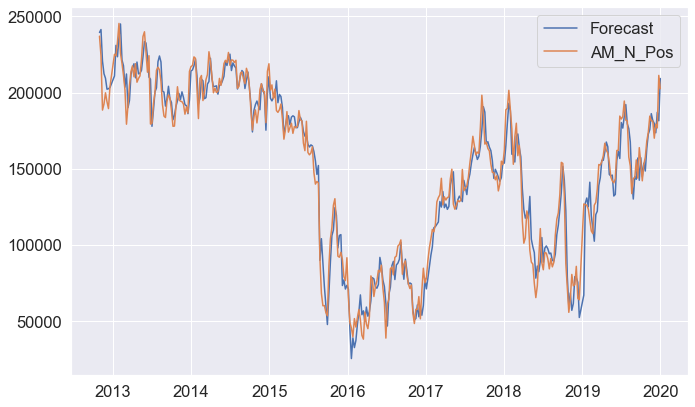

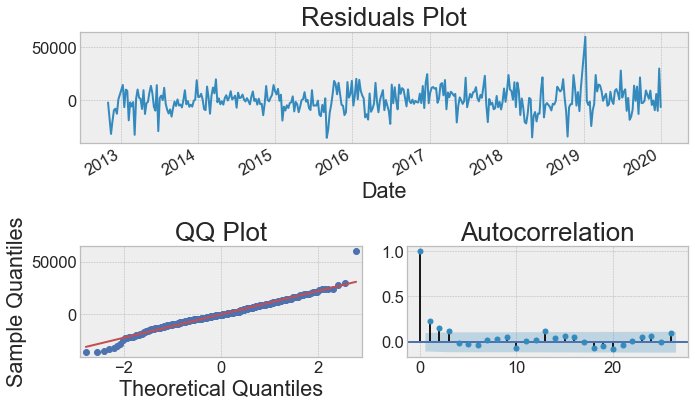

In [79]:
evaluate('Lasso', y_true, pred,lags = None, figsize = (10,6), style = 'bmh')

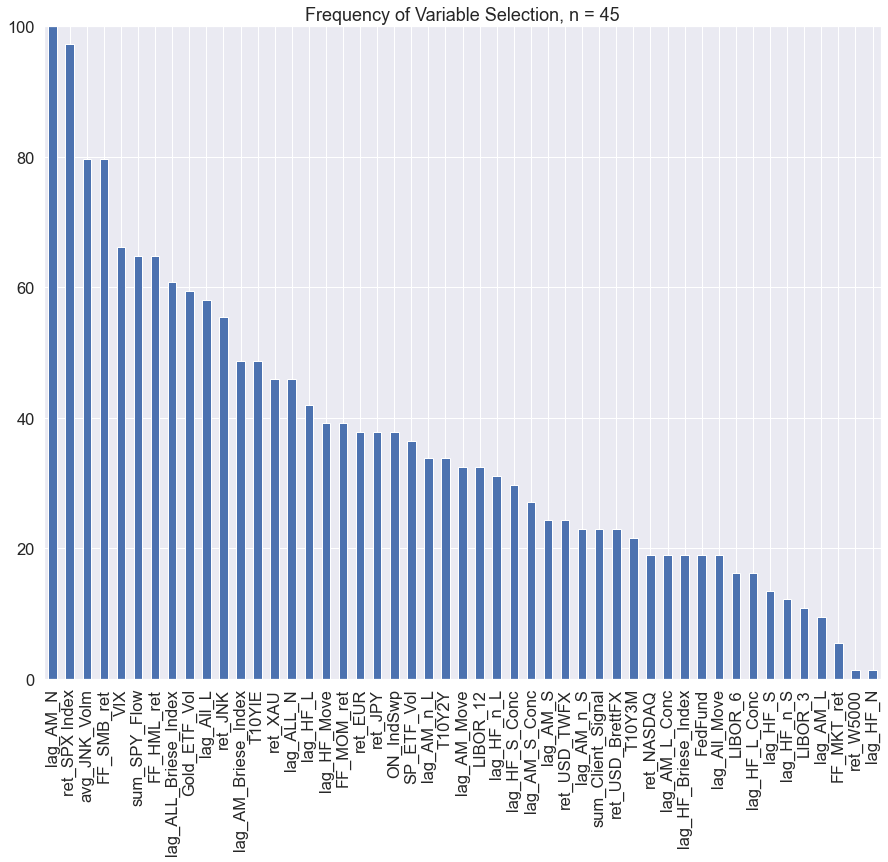

In [87]:
fig = plt.figure(figsize = (15,12))
selected = list(var_sel.values())
flat_sel = [item for sublist in selected for item in sublist]
sel = pd.Series(flat_sel)
pct = sel.value_counts()
pct = pct/74*100
pct.plot(kind='bar', ylim=(0,100) )
plt.title("Frequency of Variable Selection, n = 45")
plt.show()

In [ ]:
pos_score['Lasso'] = 

MAE on training set: 6373.25
MAE on testing set: 9714.59


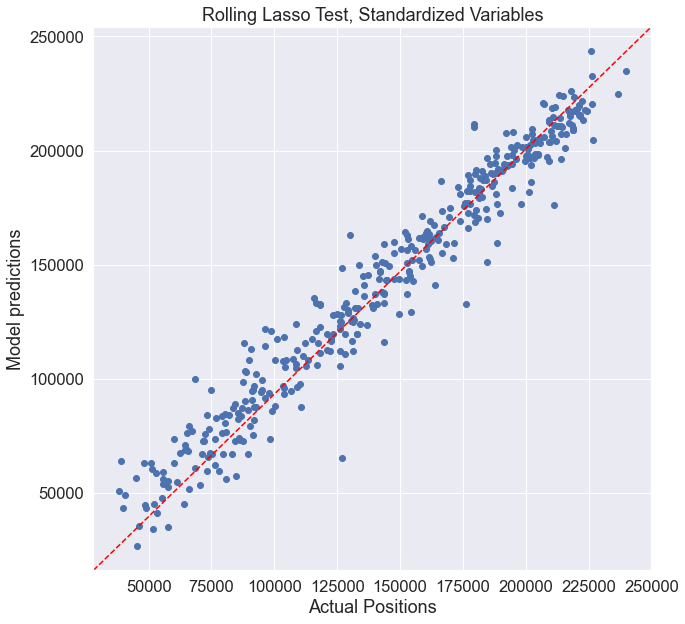

In [390]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(sample, pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.title('Rolling Lasso Test, Standardized Variables')
plt.ylabel('Model predictions')
plt.xlabel('Actual Positions')
print(string_score)

In [186]:
benchmark_res = pd.DataFrame(index = ['Ridge', 'Lasso', 'RF'], columns = ['MSE', 'MAE'])

__Ridge__

In [195]:
ridge = RidgeCV(alphas = np.linspace(0.1,1,100))
ridge.fit(X_train_std, y_train)
print("CV alpha: ",ridge.alpha_)

benchmark_res.loc['Ridge', 'MSE'] = mean_squared_error(y_test, ridge.predict(X_test_std))
benchmark_res.loc['Ridge', 'MAE'] =  mean_absolute_error(y_test, ridge.predict(X_test_std))

CV alpha:  0.1


MAE on training set: 5851.77
MAE on testing set: 11219.96


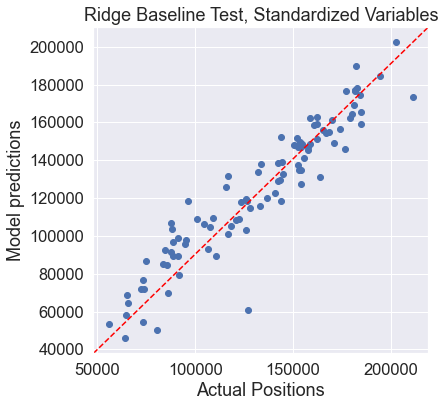

In [196]:
y_pred = ridge.predict(X_train_std)
mae = mean_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f}'
y_pred = ridge.predict(X_test_std)
mae = mean_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f}'

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.title('Ridge Baseline Test, Standardized Variables')
plt.ylabel('Model predictions')
plt.xlabel('Actual Positions')
print(string_score)

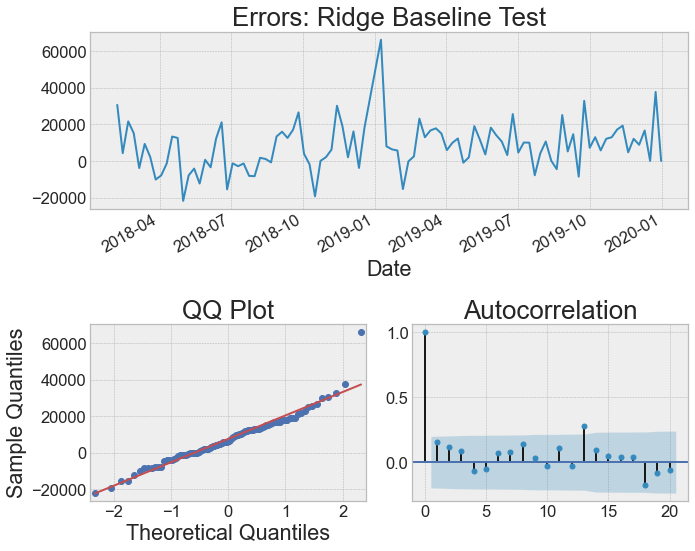

In [197]:
tsplot(y_test-y_pred,title = "Errors: Ridge Baseline Test")

(-0.05244627058970836,
 1.3213716823838757,
 -47709.394756243186,
 29441.92080149055)

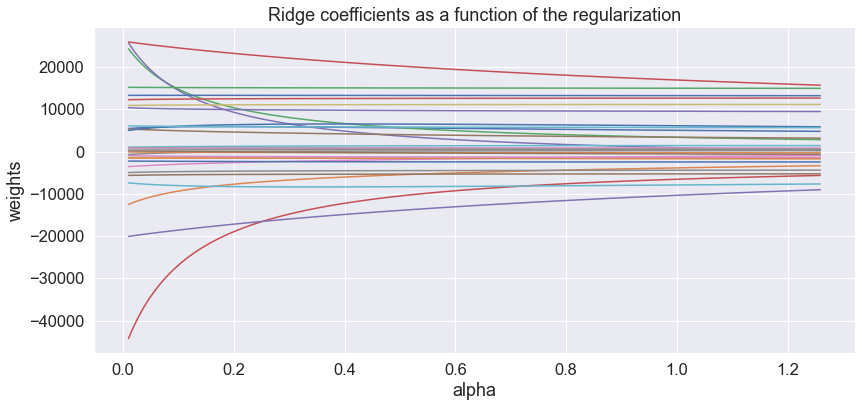

In [198]:
clf = Ridge()

coefs = []
errors = []

alphas = np.logspace(-2,.1,100)

# Train the model with different regularisation strengths
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X_train_std, y_train)
    coefs.append(clf.coef_)
    

plt.figure(figsize=(30, 6))

plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, coefs)
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')


__Lasso__

In [54]:
X_full = df.iloc[:,1:].dropna(axis = 1)
y_full = df.iloc[:,0]
X_train = X_full.iloc[30:395,:]
X_test = X_full.iloc[395:493,:]
y_train = y_full.iloc[30:395]
y_test = y_full.iloc[395:493]

scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)



In [55]:
lasso = LassoCV(max_iter = 10000, alphas = np.logspace(.1,3,100))
lasso.fit(X_train_std, y_train)

LassoCV(alphas=array([   1.25892541,    1.34676844,    1.44074081,    1.54127022,
          1.64881419,    1.76386217,    1.88693776,    2.0186011 ,
          2.1594514 ,    2.3101297 ,    2.47132176,    2.64376119,
          2.82823278,    3.0255761 ,    3.23668929,    3.46253315,
          3.70413553,    3.96259601,    4.23909088,    4.53487851,
          4.85130507,    5.18981068,    5.55193591,    5.93932887,
          6.35375264,    6.79709332,    7.27136862,    7.77873705,
          8.32150772,    8.90215085,    9....
        161.84187792,  173.13458823,  185.21526088,  198.1388769 ,
        211.96425366,  226.75431259,  242.57636554,  259.50242114,
        277.60951248,  296.98004774,  317.70218523,  339.87023462,
        363.58508612,  388.9546697 ,  416.09444628,  445.12793318,
        476.1872663 ,  509.41380148,  544.95875783,  582.98390597,
        623.66230422,  667.17908629,  713.7323038 ,  763.53382765,
        816.81031231,  873.8042273 ,  934.77496078, 1000.        ]),

In [57]:
print(np.log(lasso.alpha_))
#benchmark_res.loc['Lasso', 'MSE'] = mean_squared_error(y_test, lasso.predict(X_test_std))
#benchmark_res.loc['Lasso', 'MAE'] =  mean_absolute_error(y_test, lasso.predict(X_test_std))

5.896013344181723


MAE on training set: 6146.35
MAE on testing set: 12327.13


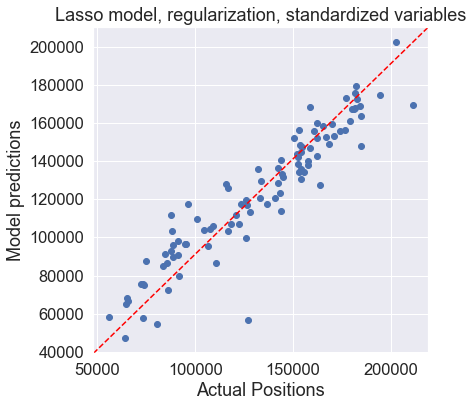

In [58]:
y_pred = lasso.predict(X_train_std)
mae = mean_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f}'
y_pred = lasso.predict(X_test_std)
mae = mean_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f}'

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.title('Lasso model, regularization, standardized variables')
plt.ylabel('Model predictions')
plt.xlabel('Actual Positions')
print(string_score)

In [210]:
print("Lasso Variable Selection:")
vars = list(X_train.columns[np.abs(lasso.coef_ - 0) > 1e-4])
vars

Lasso Variable Selection:


['T10Y3M',
 'T10Y2Y',
 'T10YIE',
 'ret_EUR',
 'ret_SPX Index',
 'ret_XAU',
 'sum_SPY_Flow',
 'avg_JNK_Volm',
 'VIX',
 'Gold_ETF_Vol',
 'lag_AM_N',
 'lag_HF_L',
 'lag_All_L',
 'lag_ALL_N']

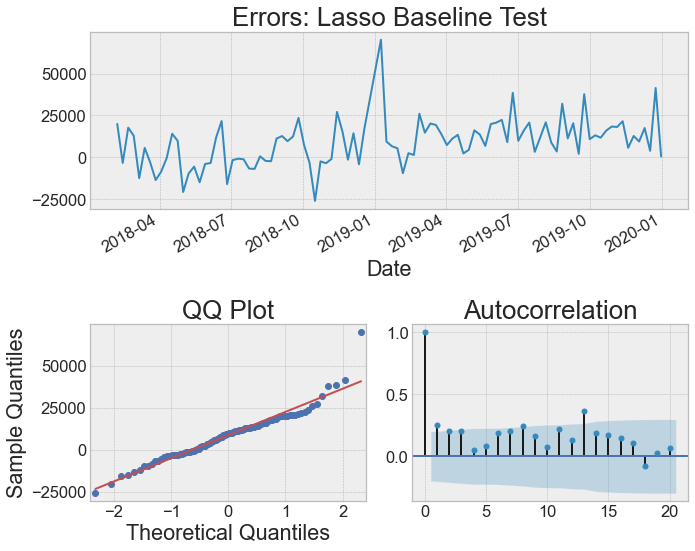

In [211]:
tsplot(y_test-y_pred,title = "Errors: Lasso Baseline Test")

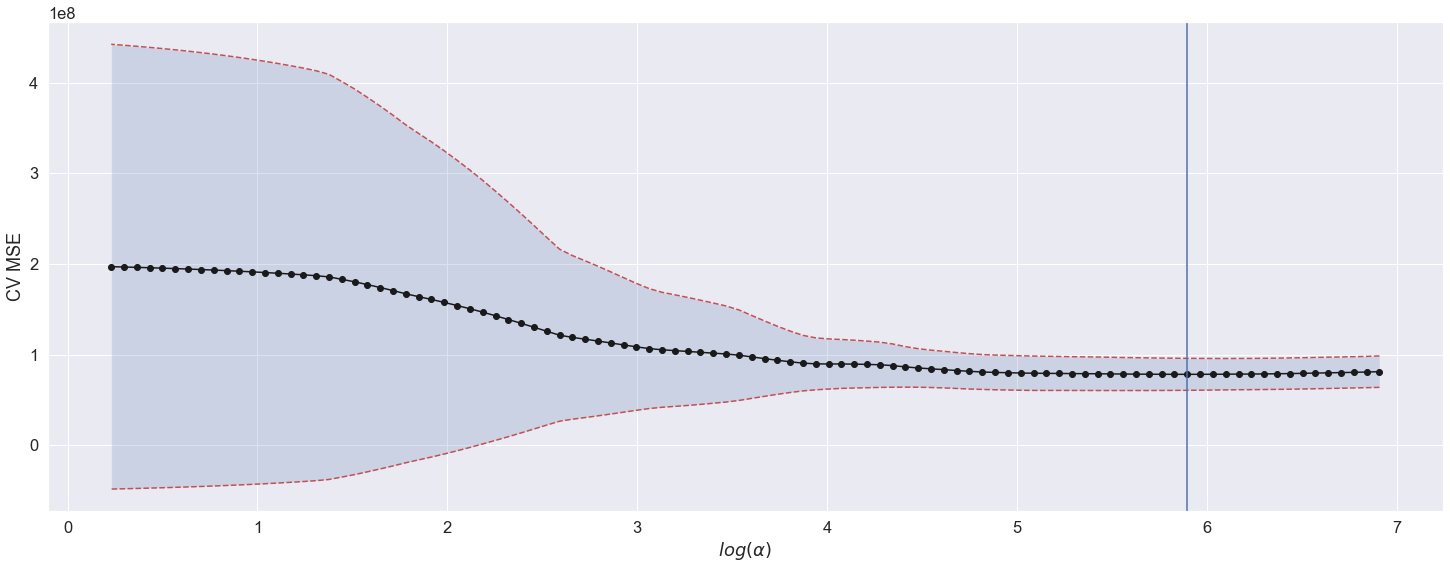

In [212]:
alpha_range = lasso.alphas_
mse_values = lasso.mse_path_.mean(axis = 1)
sd_values = lasso.mse_path_.std(axis = 1)
plt.figure(figsize=(25, 9))

plt.plot(np.log(alpha_range), mse_values ,"ko-")
plt.plot(np.log(alpha_range), mse_values + sd_values,"r--")
plt.plot(np.log(alpha_range), mse_values - sd_values,"r--")
plt.fill_between(np.log(alpha_range),
                mse_values + sd_values,
                mse_values - sd_values, alpha = .2)
plt.axvline(np.log(lasso.alpha_))
plt.xlabel(r"$log(\alpha)$")
plt.ylabel("CV MSE");

__Random Forest__

In [213]:
rf = RandomForestRegressor(n_estimators = 20)
rf.fit(X_train_std, y_train)

benchmark_res.loc['RF', 'MSE'] = mean_squared_error(y_test, rf.predict(X_test_std))
benchmark_res.loc['RF', 'MAE'] = mean_absolute_error(y_test, rf.predict(X_test_std))

y_pred = rf.predict(X_train_std)
mae = mean_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f}'
y_pred = rf.predict(X_test_std)
mae = mean_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f}'
print(string_score)

MAE on training set: 3095.03
MAE on testing set: 11419.73


MAE on training set: 3095.03
MAE on testing set: 11419.73


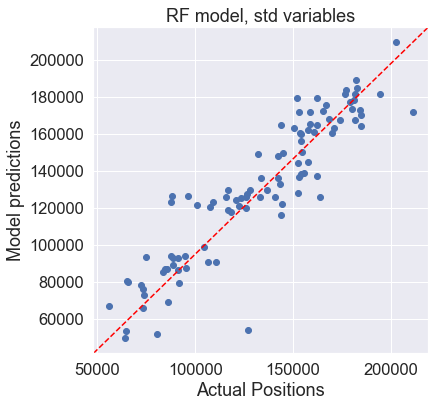

In [214]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.title('RF model, std variables')
plt.ylabel('Model predictions')
plt.xlabel('Actual Positions')
print(string_score)

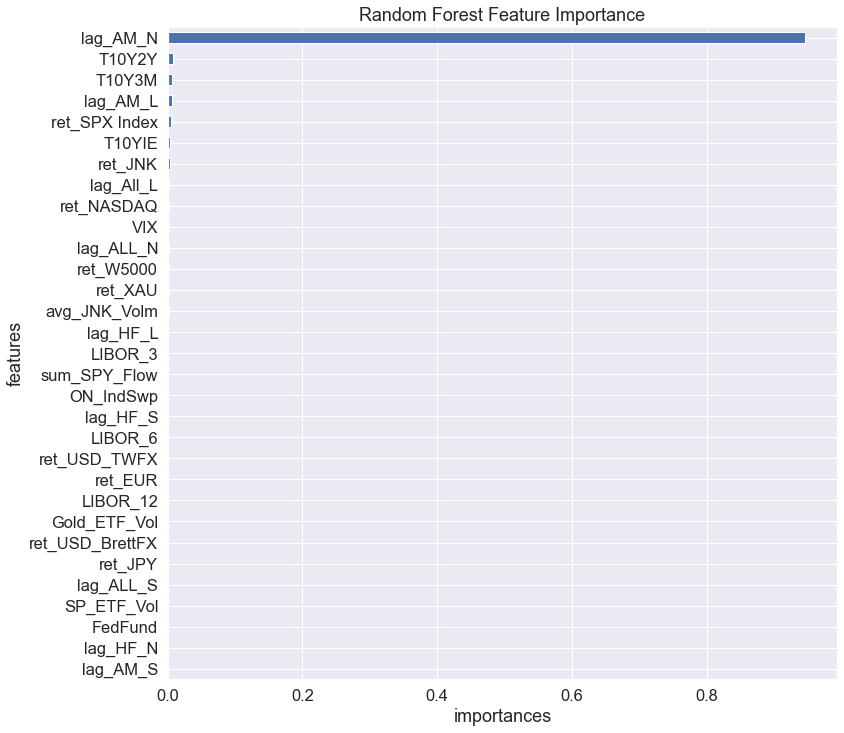

In [215]:

feat_importance = pd.Series(rf.feature_importances_, index = X_train.columns)
fis = np.argsort(feat_importance)
feat_importance = feat_importance[fis]
fig = plt.figure(figsize = [12,12])
ax = fig.subplots(1,1)
feat_importance.plot(kind = 'barh', ax = ax)
plt.ylabel('features')
plt.xlabel('importances')
plt.title("Random Forest Feature Importance")
plt.show()

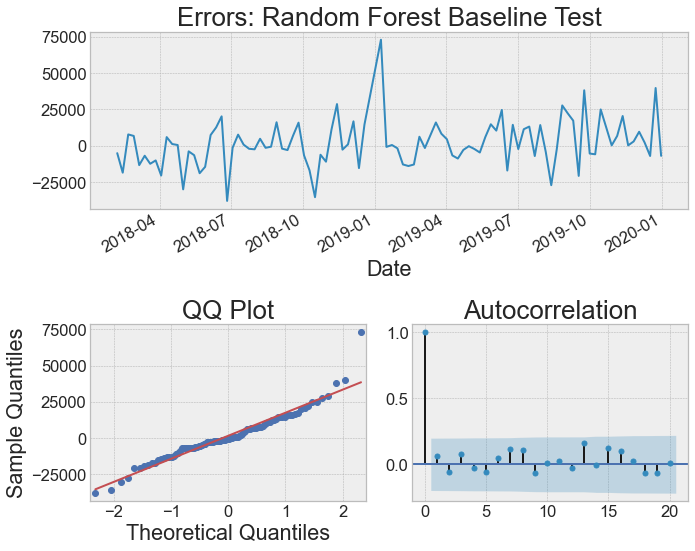

In [216]:
y_pred = rf.predict(X_test_std)
tsplot(y_test-y_pred,title = "Errors: Random Forest Baseline Test")

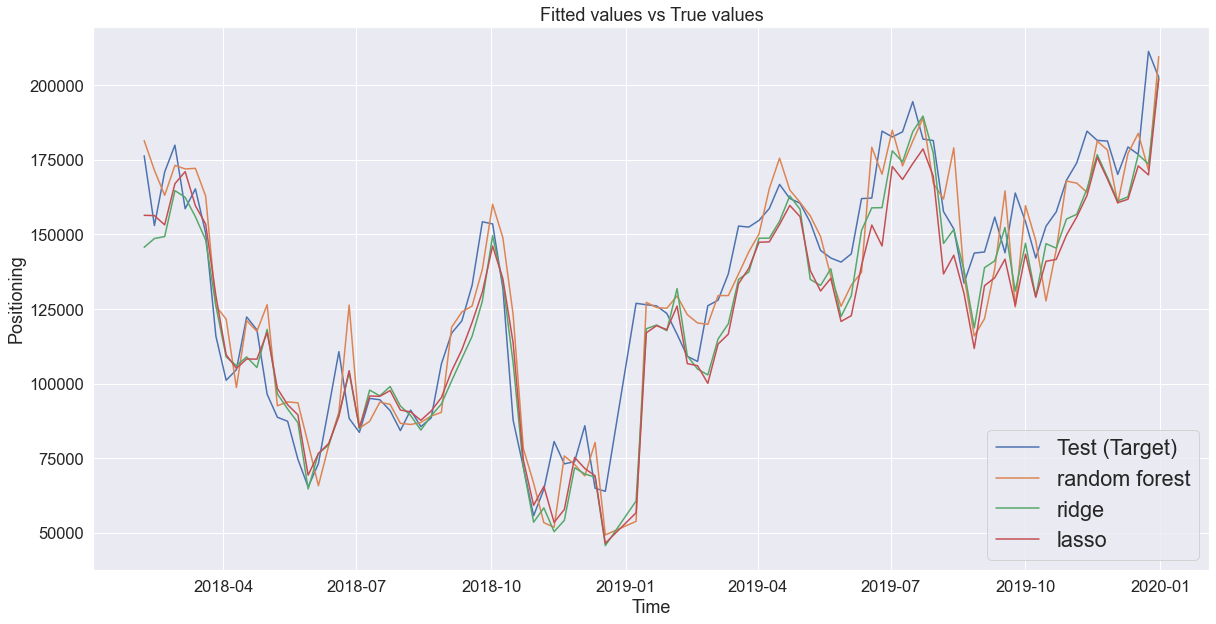

In [217]:
fig = plt.figure(figsize = [20,10])
plt.plot(X_test.index, y_test, label = 'Test (Target)')
plt.plot(X_test.index, rf.predict(X_test_std), label = 'random forest')
plt.plot(X_test.index, ridge.predict(X_test_std), label = 'ridge')
plt.plot(X_test.index, lasso.predict(X_test_std), label = 'lasso')
plt.xlabel("Time")
plt.ylabel("Positioning")
plt.title('Fitted values vs True values')
plt.legend(fontsize = 'large')

In [218]:
benchmark_res

MSE      MAE
Ridge          NaN      NaN
Lasso  2.66744e+08    12531
RF     2.54459e+08  11419.7

__Predict Change in AM Position__

In [227]:
#reimporting, so we do difference and lag at same time
train = df.iloc[30:395,:]
test = df.iloc[395:493,:]
benchmark_res = pd.DataFrame(index = ['Ridge', 'Lasso', 'RF'], columns = ['MSE', 'MAE'])

In [228]:
train.columns

Index(['AM_N', 'FedFund', 'ON_IndSwp', 'LIBOR_3', 'LIBOR_6', 'LIBOR_12',
       'T10Y3M', 'T10Y2Y', 'T10YIE', 'ret_USD_TWFX', 'ret_USD_BrettFX',
       'ret_EUR', 'ret_JPY', 'ret_JNK', 'ret_SPX Index', 'ret_W5000',
       'ret_NASDAQ', 'ret_XAU', 'sum_SPY_Flow', 'avg_JNK_Volm', 'VIX',
       'SP_ETF_Vol', 'Gold_ETF_Vol', 'lag_AM_N', 'lag_AM_L', 'lag_AM_S',
       'lag_HF_N', 'lag_HF_L', 'lag_HF_S', 'lag_All_L', 'lag_ALL_S',
       'lag_ALL_N'],
      dtype='object')

In [229]:
train['d_AM_NetPos'] = train['AM_N'].diff()
test['d_AM_NetPos'] = test['AM_N'].diff()
train.iloc[0,len(train.columns)-1]=0
test.iloc[0,len(test.columns)-1]=0


In [230]:
cols = ['AM_N']  #cols to drop
train = train.drop(columns = cols)
test = test.drop(columns = cols)




In [231]:
#pop modifies original data frame
y_train = train.pop('d_AM_NetPos')
y_test = test.pop('d_AM_NetPos')

In [232]:
X_train = train
X_test = test
train['year'] = train.index.year

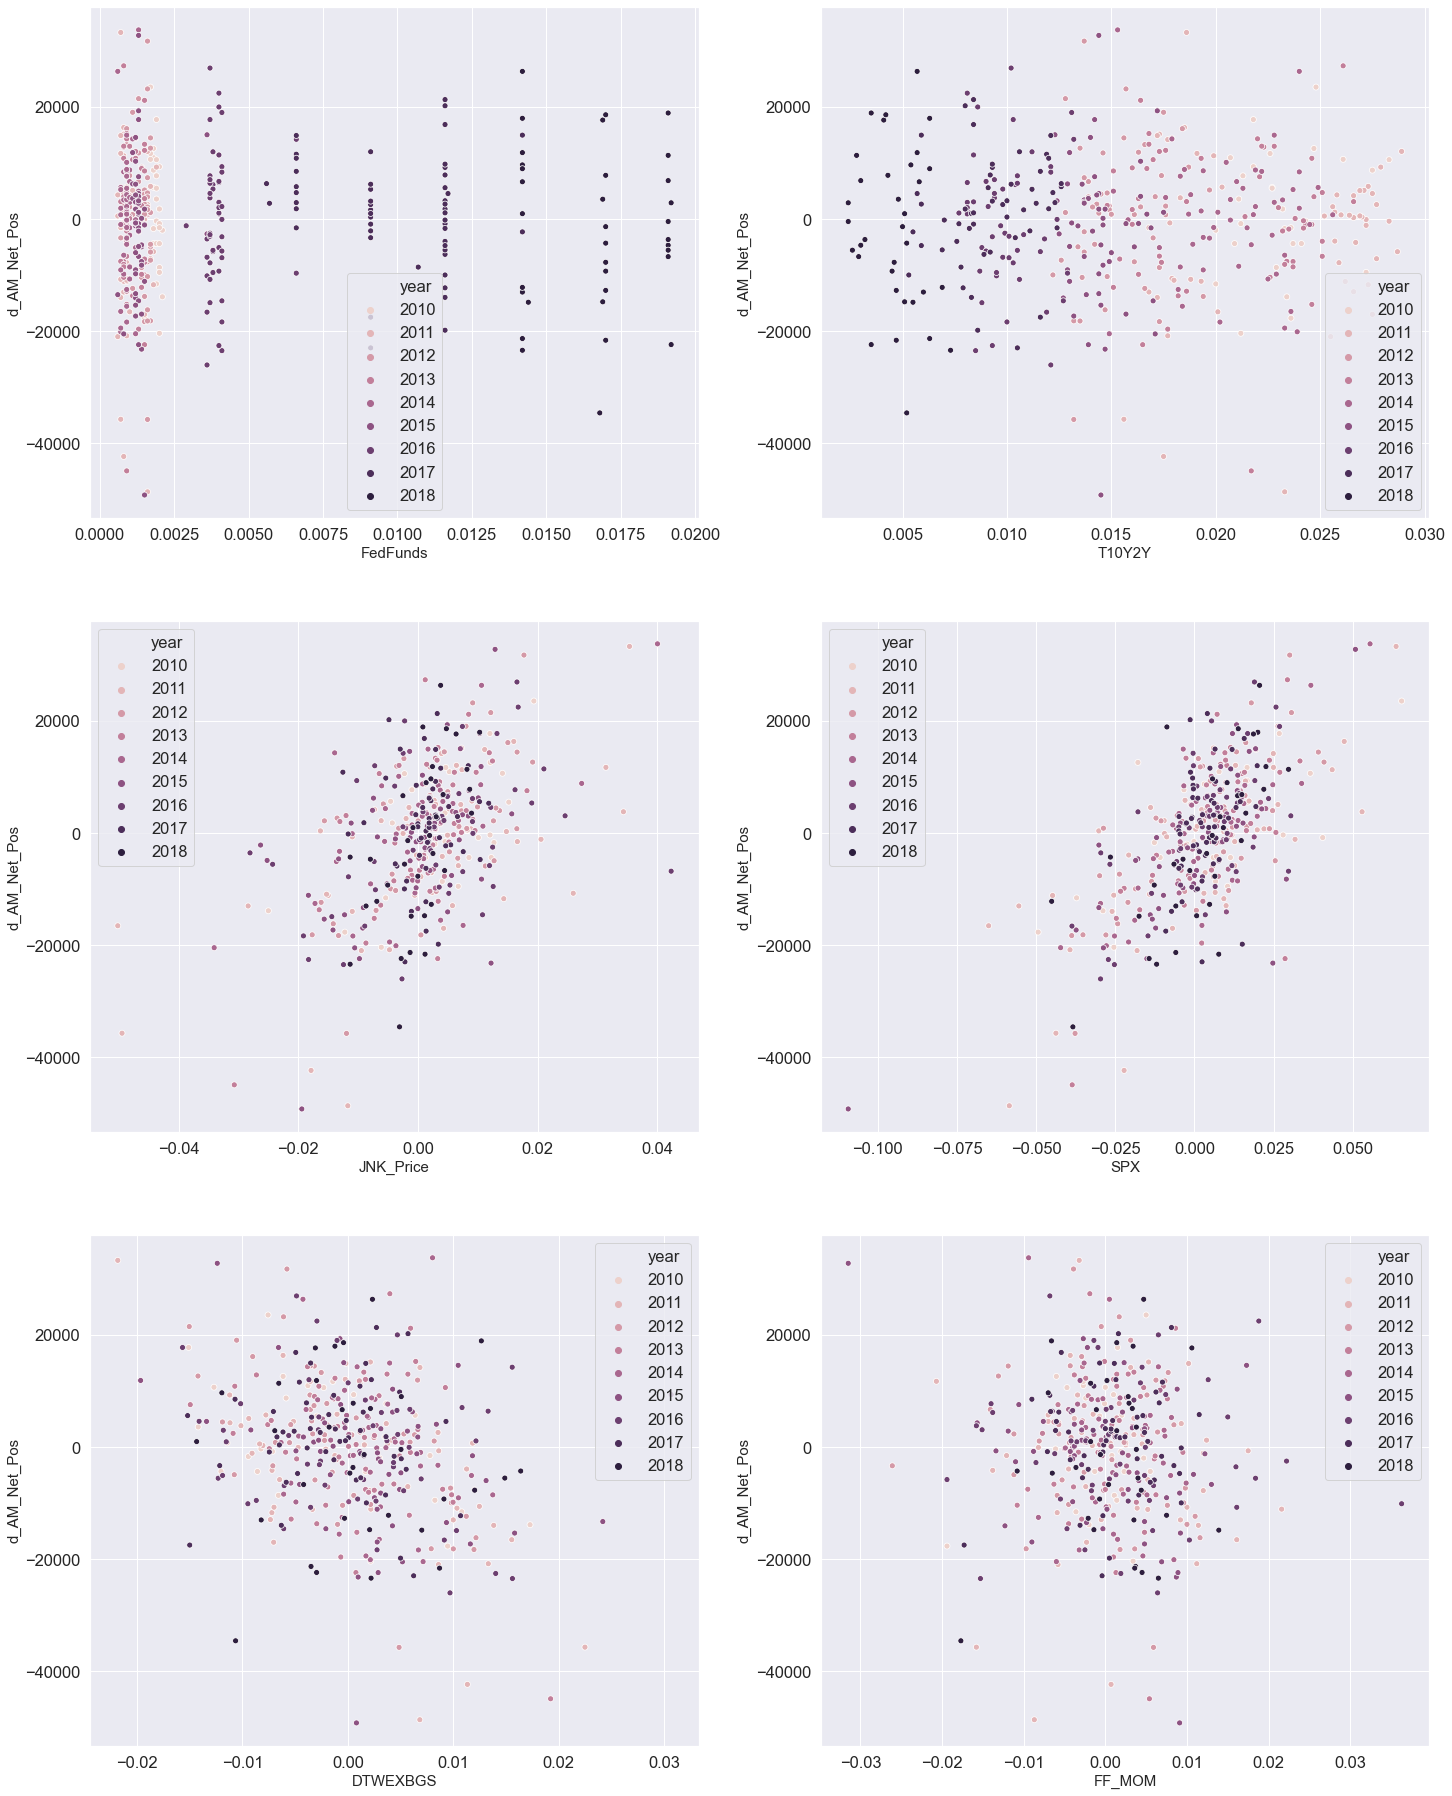

In [43]:
#look at one of each Asset Type Across Time
fig = plt.figure(figsize = (24,32))
sns.set(font_scale = 1.5)
axs = fig.subplots(3,2)
picklst = ['FedFunds', 'T10Y2Y', 'JNK_Price', 'SPX','DTWEXBGS','FF_MOM','SPY Flows','VIX']
for i in range(6):
    sns.scatterplot(x=train.loc[:,picklst[i]], y=y_train, data=train, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("d_AM_Net_Pos", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)

Text(0.5, 0, 'lag_AM_NetPos')

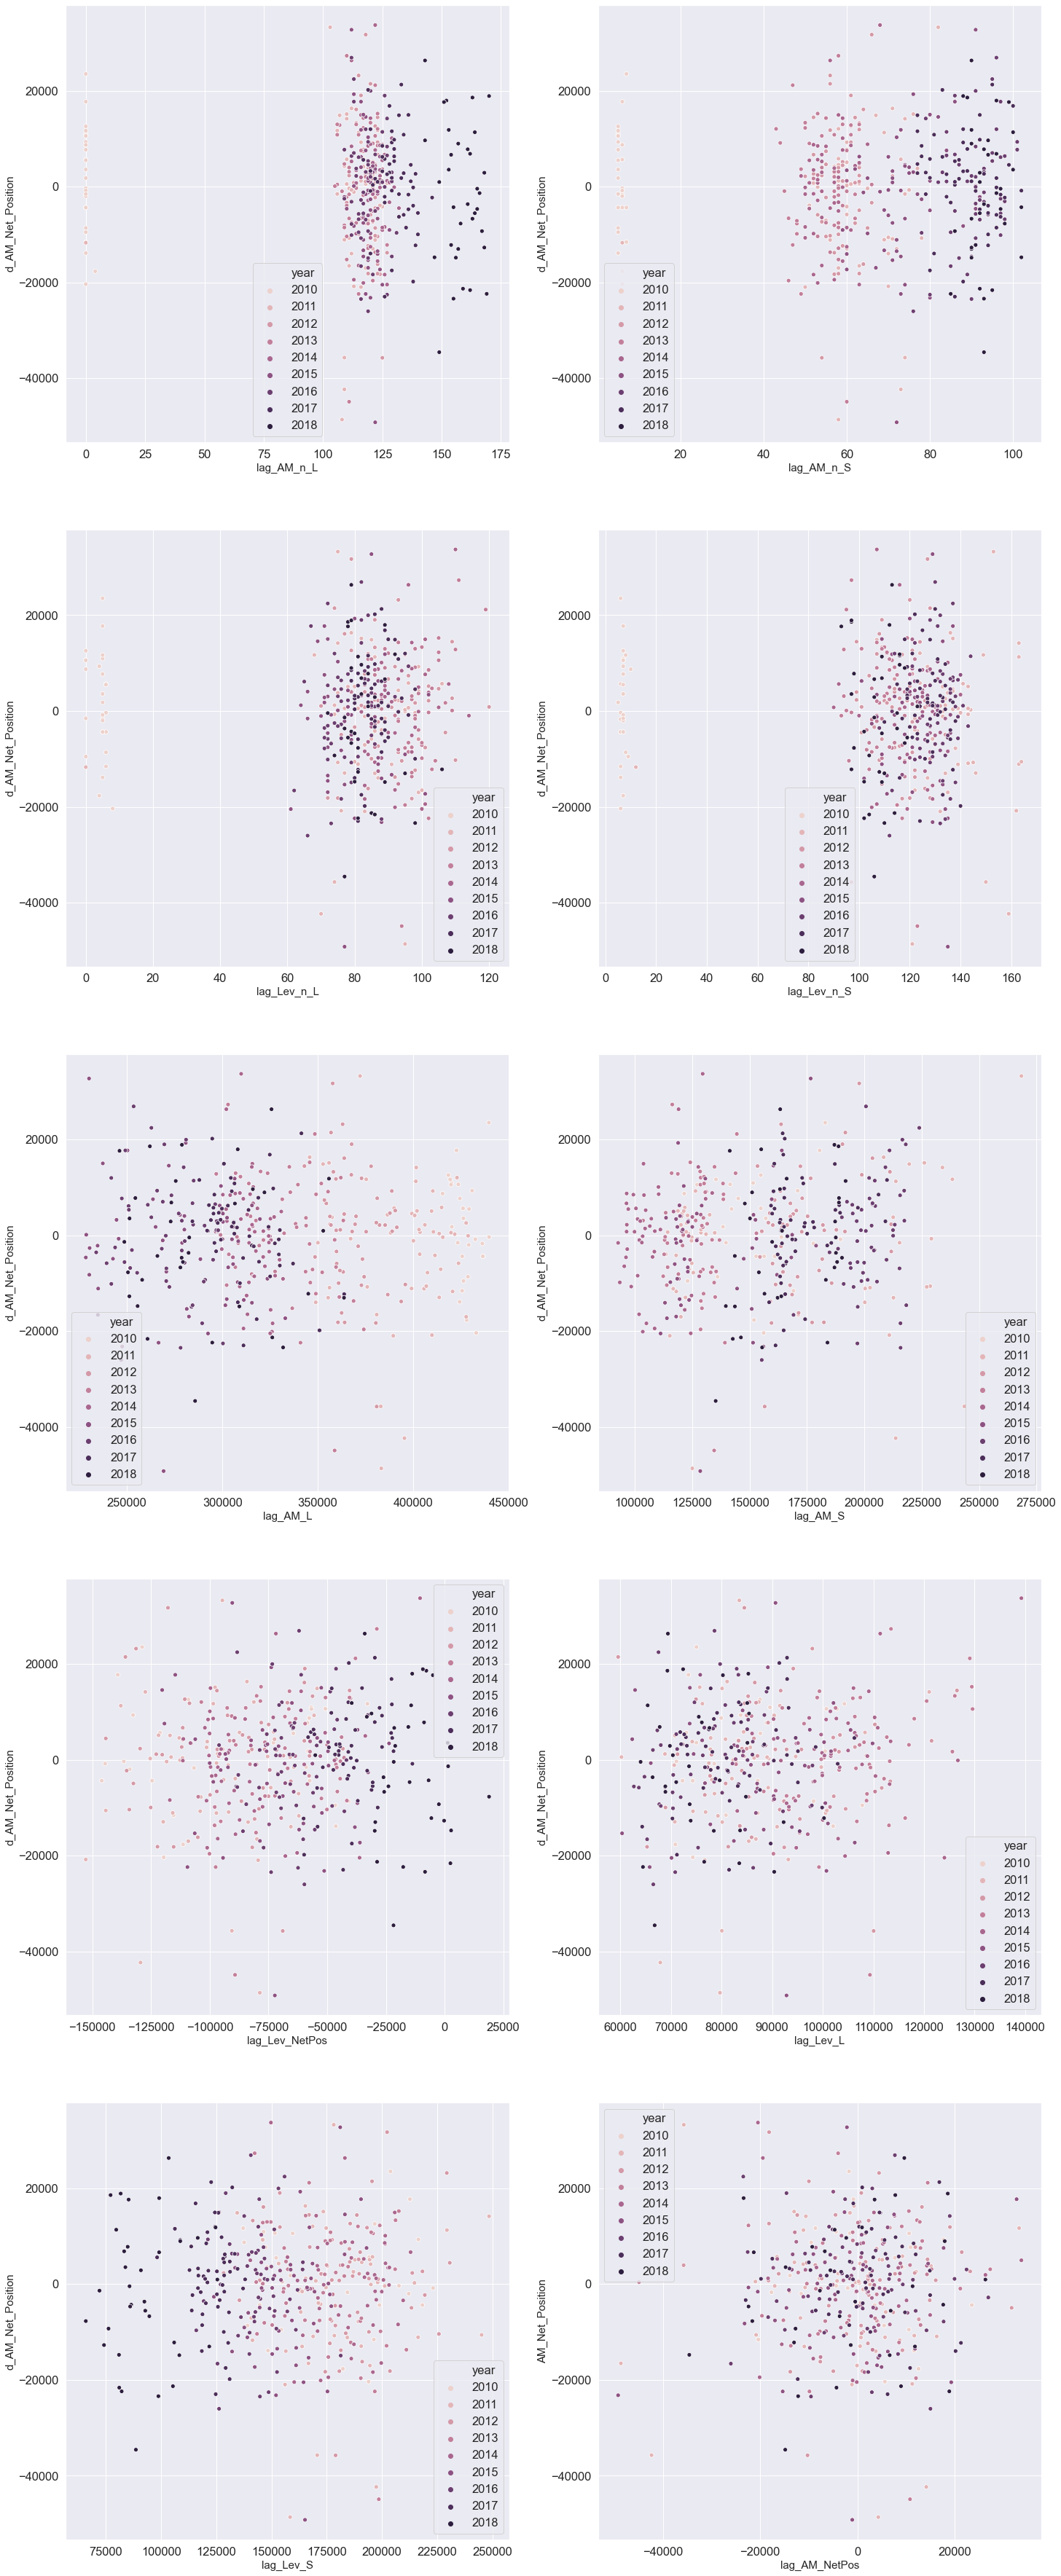

In [44]:
fig = plt.figure(figsize = (24,64))
sns.set(font_scale = 1.5)
axs = fig.subplots(5,2)
picklst = ['lag_AM_n_L', 'lag_AM_n_S', 'lag_Lev_n_L', 'lag_Lev_n_S', 'lag_AM_L', 'lag_AM_S',\
           'lag_Lev_NetPos', 'lag_Lev_L','lag_Lev_S']
for i in range(9):
    sns.scatterplot(x=train.loc[:,picklst[i]], y=y_train, data=train, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("d_AM_Net_Position", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)

sns.scatterplot(x = y_train.shift(1), y = y_train, data = train, hue = "year", legend = "full", ax = axs[4,1])
axs[4,1].set_ylabel("AM_Net_Position", fontsize = 15)
axs[4,1].set_xlabel("lag_AM_NetPos", fontsize = 15)

In [233]:

X_train = X_train.drop(columns = ['year'])


In [234]:
benchmark_res = pd.DataFrame(index = ['Ridge', 'Lasso', 'RF'], columns = ['MSE', 'MAE'])

In [235]:
from sklearn.preprocessing import StandardScaler
scaler2 = StandardScaler()
scaler2.fit(X_train)
X_train_std = scaler2.transform(X_train)
X_test_std = scaler2.transform(X_test)

In [236]:
ridge = RidgeCV(alphas = np.linspace(0.1,1,100))
ridge.fit(X_train_std, y_train)
print("CV alpha: ",ridge.alpha_)

benchmark_res.loc['Ridge', 'MSE'] = mean_squared_error(y_test, ridge.predict(X_test_std))
benchmark_res.loc['Ridge', 'MAE'] =  mean_absolute_error(y_test, ridge.predict(X_test_std))

CV alpha:  0.1


MAE on training set: 5876.42
MAE on testing set: 11202.04


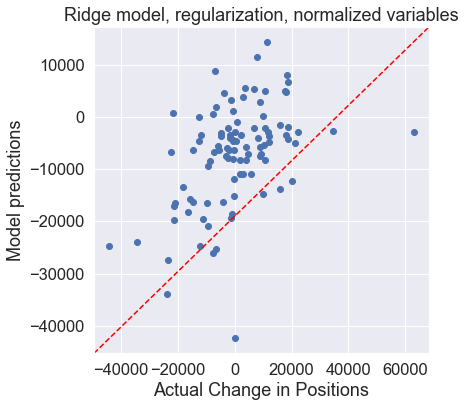

In [237]:
y_pred = ridge.predict(X_train_std)
mae = mean_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f}'
y_pred = ridge.predict(X_test_std)
mae = mean_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f}'

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.title('Ridge model, regularization, normalized variables')
plt.ylabel('Model predictions')
plt.xlabel('Actual Change in Positions')
print(string_score)

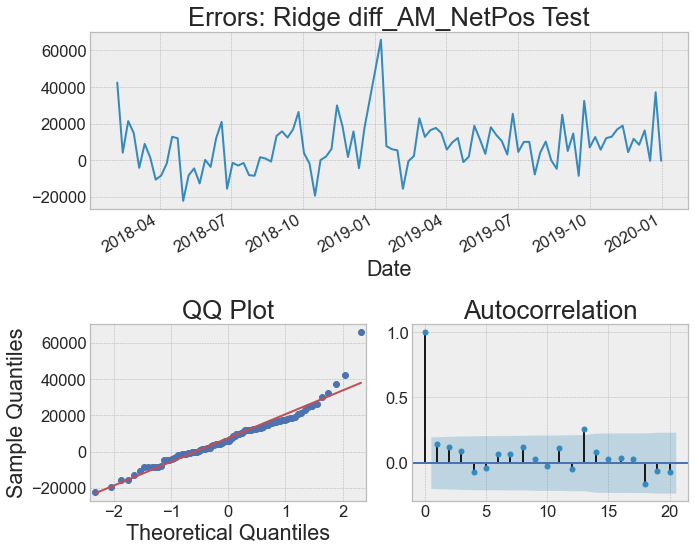

In [238]:
tsplot(y_test-y_pred,title = "Errors: Ridge diff_AM_NetPos Test")

(-0.05244627058970836,
 1.3213716823838757,
 -48742.43316939315,
 29630.354381473277)

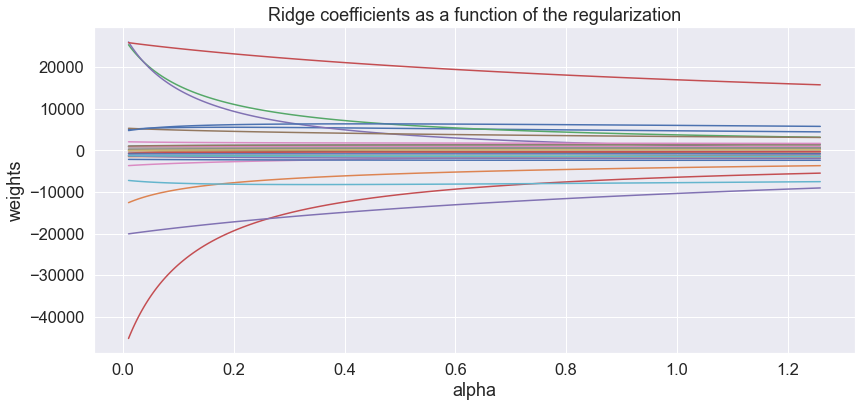

In [239]:
clf = Ridge()

coefs = []
errors = []

alphas = np.logspace(-2,.1,100)

# Train the model with different regularisation strengths
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X_train_std, y_train)
    coefs.append(clf.coef_)
    

plt.figure(figsize=(30, 6))

plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, coefs)
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')


In [240]:
lasso = LassoCV(max_iter = 10000, alphas = np.logspace(.1,3,100))
lasso.fit(X_train_std, y_train)

LassoCV(alphas=array([   1.25892541,    1.34676844,    1.44074081,    1.54127022,
          1.64881419,    1.76386217,    1.88693776,    2.0186011 ,
          2.1594514 ,    2.3101297 ,    2.47132176,    2.64376119,
          2.82823278,    3.0255761 ,    3.23668929,    3.46253315,
          3.70413553,    3.96259601,    4.23909088,    4.53487851,
          4.85130507,    5.18981068,    5.55193591,    5.93932887,
          6.35375264,    6.79709332,    7.27136862,    7.77873705,
          8.32150772,    8.90215085,    9....
        161.84187792,  173.13458823,  185.21526088,  198.1388769 ,
        211.96425366,  226.75431259,  242.57636554,  259.50242114,
        277.60951248,  296.98004774,  317.70218523,  339.87023462,
        363.58508612,  388.9546697 ,  416.09444628,  445.12793318,
        476.1872663 ,  509.41380148,  544.95875783,  582.98390597,
        623.66230422,  667.17908629,  713.7323038 ,  763.53382765,
        816.81031231,  873.8042273 ,  934.77496078, 1000.        ]),

In [241]:
print(np.log(lasso.alpha_))
benchmark_res.loc['Lasso', 'MSE'] = mean_squared_error(y_test, lasso.predict(X_test_std))
benchmark_res.loc['Lasso', 'MAE'] =  mean_absolute_error(y_test, lasso.predict(X_test_std))

5.896013344181723


In [242]:
print("Lasso Variable Selection:")
vars = list(X_train.columns[np.abs(lasso.coef_ - 0) > 1e-4])
vars

Lasso Variable Selection:


['ret_EUR',
 'ret_JNK',
 'ret_SPX Index',
 'ret_XAU',
 'sum_SPY_Flow',
 'avg_JNK_Volm',
 'VIX',
 'Gold_ETF_Vol',
 'lag_AM_N',
 'lag_AM_S',
 'lag_HF_N',
 'lag_HF_L']

MAE on training set: 6373.25
MAE on testing set: 9714.59


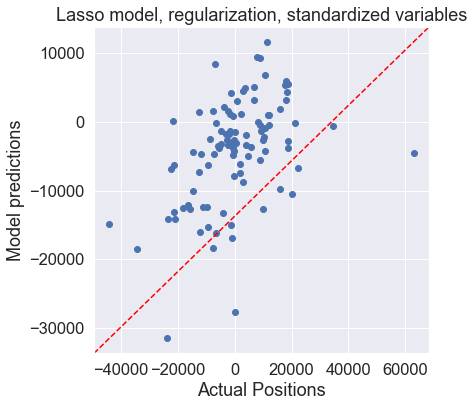

In [243]:
y_pred = lasso.predict(X_train_std)
mae = mean_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: {mae:.2f}'
y_pred = lasso.predict(X_test_std)
mae = mean_absolute_error(y_test, y_pred)
string_score += f'\nMAE on testing set: {mae:.2f}'

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.title('Lasso model, regularization, standardized variables')
plt.ylabel('Model predictions')
plt.xlabel('Actual Positions')
print(string_score)

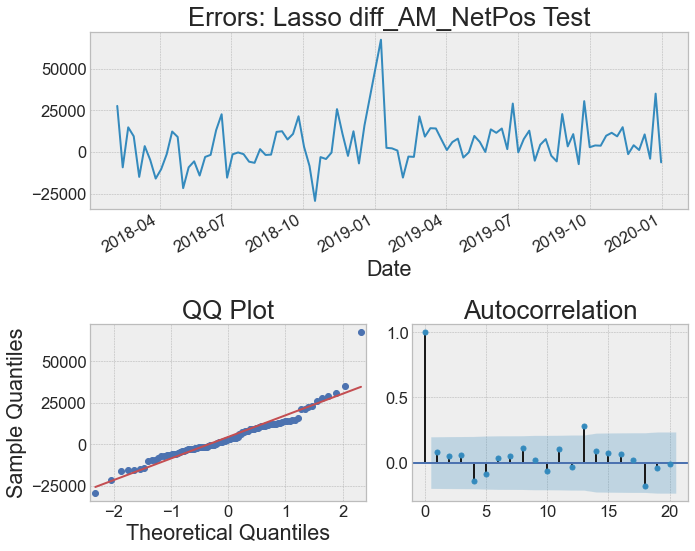

In [244]:
tsplot(y_test-y_pred,title = "Errors: Lasso diff_AM_NetPos Test")

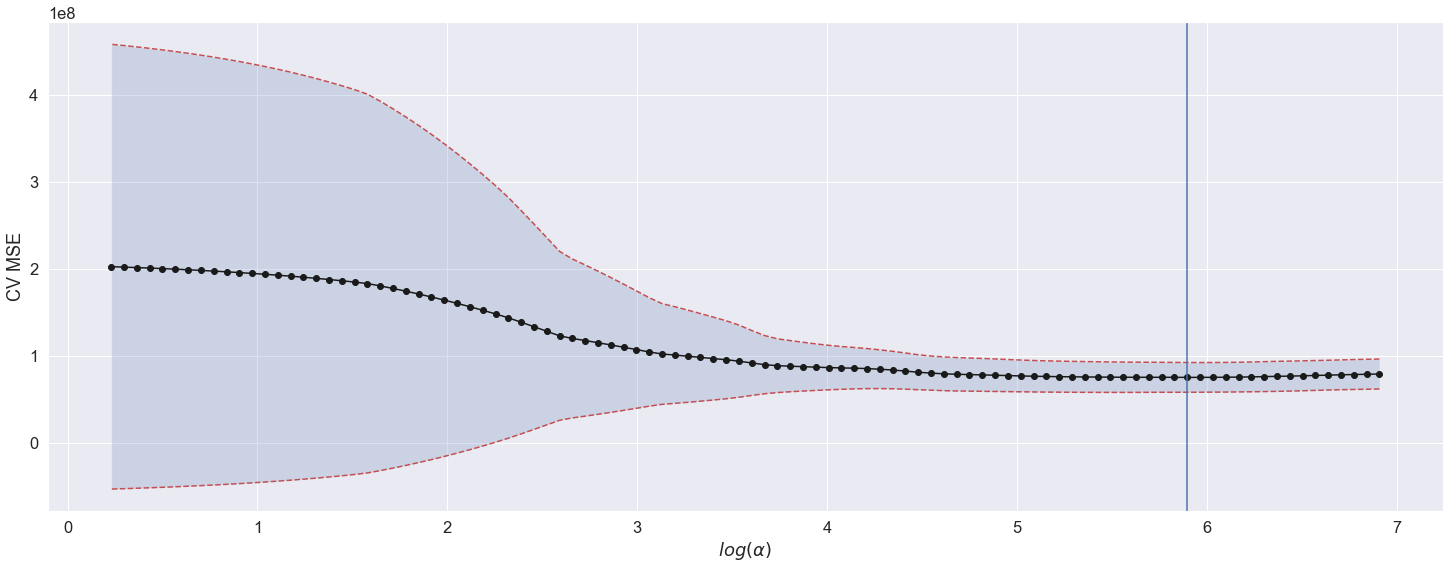

In [245]:
alpha_range = lasso.alphas_
mse_values = lasso.mse_path_.mean(axis = 1)
sd_values = lasso.mse_path_.std(axis = 1)
plt.figure(figsize=(25, 9))
plt.plot(np.log(alpha_range), mse_values ,"ko-")
plt.plot(np.log(alpha_range), mse_values + sd_values,"r--")
plt.plot(np.log(alpha_range), mse_values - sd_values,"r--")
plt.fill_between(np.log(alpha_range),
                mse_values + sd_values,
                mse_values - sd_values, alpha = .2)

plt.axvline(np.log(lasso.alpha_))
plt.xlabel(r"$log(\alpha)$")
plt.ylabel("CV MSE");

In [246]:
X_train.columns[np.abs(lasso.coef_ - 0) > 1e-4]

Index(['ret_EUR', 'ret_JNK', 'ret_SPX Index', 'ret_XAU', 'sum_SPY_Flow',
       'avg_JNK_Volm', 'VIX', 'Gold_ETF_Vol', 'lag_AM_N', 'lag_AM_S',
       'lag_HF_N', 'lag_HF_L'],
      dtype='object')

In [247]:
rf = RandomForestRegressor(n_estimators = 20)
rf.fit(X_train_std, y_train)

benchmark_res.loc['RF', 'MSE'] = mean_squared_error(y_test, rf.predict(X_test_std))
benchmark_res.loc['RF', 'MAE'] = mean_absolute_error(y_test, rf.predict(X_test_std))

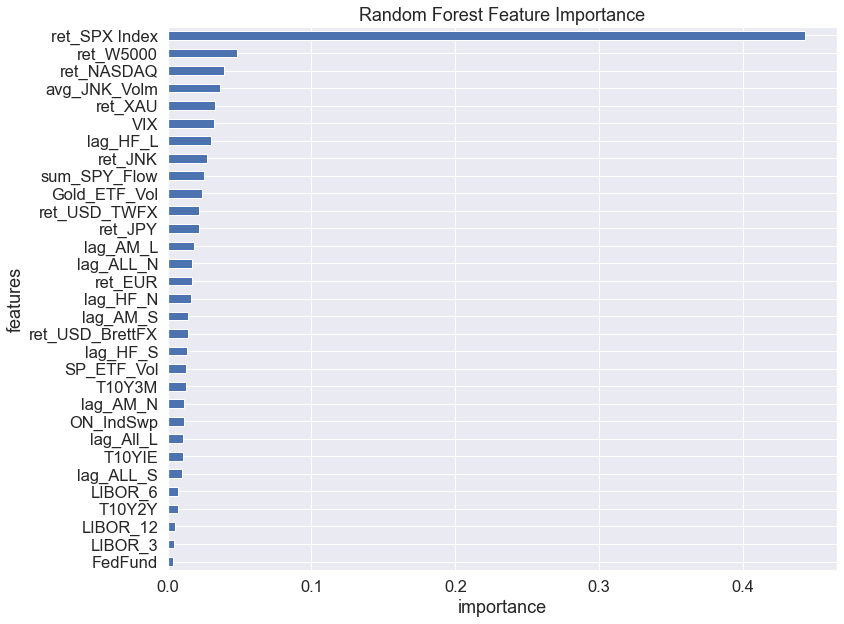

In [248]:
feat_importance = pd.Series(rf.feature_importances_, index = X_train.columns)
fis = np.argsort(feat_importance)
feat_importance = feat_importance[fis]
fig = plt.figure(figsize = [12,10])
ax = fig.subplots(1,1)
feat_importance.plot(kind = 'barh', ax = ax)
plt.ylabel('features')
plt.xlabel('importance')
plt.title("Random Forest Feature Importance")
plt.show()

MAE on training set: 6373.25
MAE on testing set: 9714.59


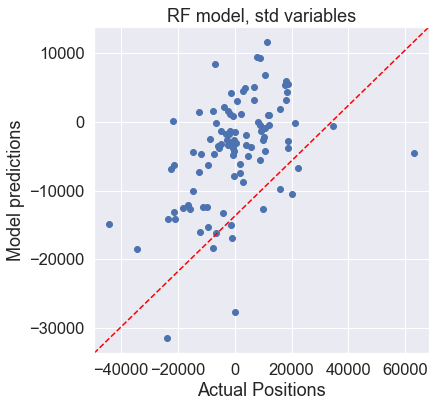

In [249]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")

plt.title('RF model, std variables')
plt.ylabel('Model predictions')
plt.xlabel('Actual Positions')
print(string_score)

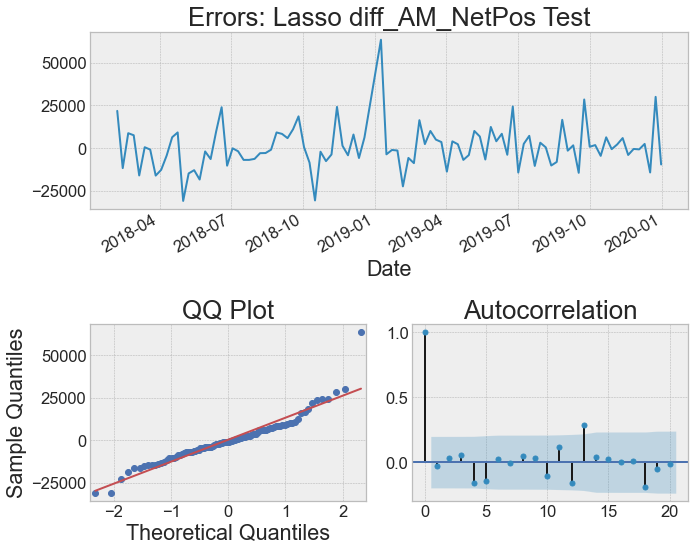

In [250]:
y_pred = rf.predict(X_test_std)
tsplot(y_test-y_pred,title = "Errors: Lasso diff_AM_NetPos Test")

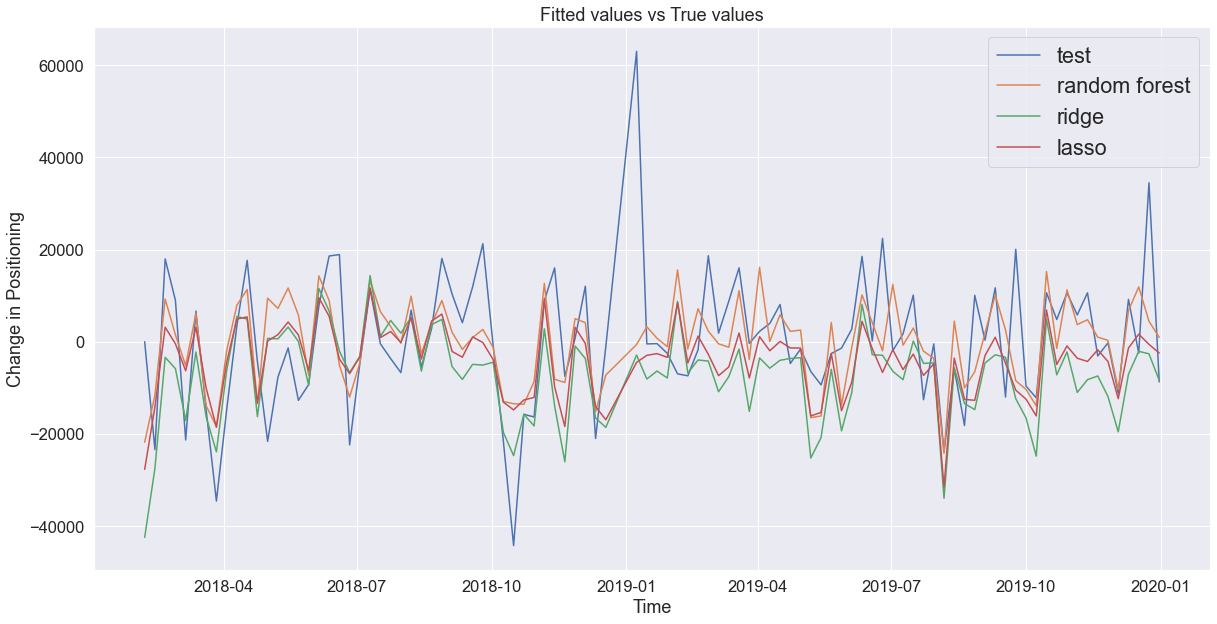

In [251]:
fig = plt.figure(figsize = [20,10])
plt.plot(test.index, y_test, label = 'test')
plt.plot(test.index, rf.predict(X_test_std), label = 'random forest')
plt.plot(test.index, ridge.predict(X_test_std), label = 'ridge')
plt.plot(test.index, lasso.predict(X_test_std), label = 'lasso')
plt.xlabel("Time")
plt.ylabel("Change in Positioning")
plt.title('Fitted values vs True values')
plt.legend(fontsize = 'large')

In [252]:
benchmark_res

MSE      MAE
Ridge  2.27714e+08    11202
Lasso  1.87641e+08  9714.59
RF     1.66707e+08  9045.01

In [253]:
fis = np.argsort(feat_importance)
feat_importance = feat_importance[fis]
print(feat_importance.sort_values(ascending = False)[0:10])

ret_SPX Index    0.443547
ret_W5000        0.048417
ret_NASDAQ       0.039004
avg_JNK_Volm     0.036386
ret_XAU          0.032958
VIX              0.032274
lag_HF_L         0.029896
ret_JNK          0.027344
sum_SPY_Flow     0.024978
Gold_ETF_Vol     0.023614
dtype: float64
